In [67]:
import numpy as np


In [68]:
def compute_homography(pts1_, pts2_, shape):
    """Compute the homography matrix from 4 point correspondences"""
    # Rescale to actual size
    shape = np.array(shape[::-1], dtype=np.float32)  # different convention [y, x]
    pts1 = pts1_ * np.expand_dims(shape, axis=0)
    pts2 = pts2_ * np.expand_dims(shape, axis=0)

    def ax(p, q):
        return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]

    def ay(p, q):
        return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

    a_mat = np.stack([f(pts1[i], pts2[i]) for i in range(4) for f in (ax, ay)], axis=0)
    p_mat = np.transpose(
        np.stack([[pts2[i][j] for i in range(4) for j in range(2)]], axis=0)
    )
    homography = np.transpose(np.linalg.solve(a_mat, p_mat))
    return flat2mat(homography)

def check_convex(patch, min_convexity=0.05):
    """Checks if given polygon vertices [N,2] form a convex shape"""
    for i in range(patch.shape[0]):
        x1, y1 = patch[(i - 1) % patch.shape[0]]
        x2, y2 = patch[i]
        x3, y3 = patch[(i + 1) % patch.shape[0]]
        if (x2 - x1) * (y3 - y2) - (x3 - x2) * (y2 - y1) > -min_convexity:
            return False
    return True


def flat2mat(H):
    return np.reshape(np.concatenate([H, np.ones_like(H[:, :1])], axis=1), [3, 3])

def create_center_patch(shape, patch_shape=None):
    if patch_shape is None:
        patch_shape = shape
    width, height = shape
    pwidth, pheight = patch_shape
    left = int((width - pwidth) / 2)
    bottom = int((height - pheight) / 2)
    right = int((width + pwidth) / 2)
    top = int((height + pheight) / 2)
    return np.array([[left, bottom], [left, top], [right, top], [right, bottom]])

def sample_homography_corners(
    shape,
    patch_shape,
    difficulty=1.0,
    translation=0.4,
    n_angles=10,
    max_angle=90,
    min_convexity=0.05,
    rng=np.random,
):
    max_angle = max_angle / 180.0 * math.pi
    width, height = shape
    pwidth, pheight = width * (1 - difficulty), height * (1 - difficulty)
    min_pts1 = create_center_patch(shape, (pwidth, pheight))
    full = create_center_patch(shape)
    pts2 = create_center_patch(patch_shape)
    scale = min_pts1 - full
    found_valid = False
    cnt = -1
    while not found_valid:
        offsets = rng.uniform(0.0, 1.0, size=(4, 2)) * scale
        pts1 = full + offsets
        found_valid = check_convex(pts1 / np.array(shape), min_convexity)
        cnt += 1

    # re-center
    pts1 = pts1 - np.mean(pts1, axis=0, keepdims=True)
    pts1 = pts1 + np.mean(min_pts1, axis=0, keepdims=True)

    # Rotation
    if n_angles > 0 and difficulty > 0:
        angles = np.linspace(-max_angle * difficulty, max_angle * difficulty, n_angles)
        rng.shuffle(angles)
        rng.shuffle(angles)
        angles = np.concatenate([[0.0], angles], axis=0)

        center = np.mean(pts1, axis=0, keepdims=True)
        rot_mat = np.reshape(
            np.stack(
                [np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)],
                axis=1,
            ),
            [-1, 2, 2],
        )
        rotated = (
            np.matmul(
                np.tile(np.expand_dims(pts1 - center, axis=0), [n_angles + 1, 1, 1]),
                rot_mat,
            )
            + center
        )

        for idx in range(1, n_angles):
            warped_points = rotated[idx] / np.array(shape)
            if np.all((warped_points >= 0.0) & (warped_points < 1.0)):
                pts1 = rotated[idx]
                break

    # Translation
    if translation > 0:
        min_trans = -np.min(pts1, axis=0)
        max_trans = shape - np.max(pts1, axis=0)
        trans = rng.uniform(min_trans, max_trans)[None]
        pts1 += trans * translation * difficulty

    H = compute_homography(pts1, pts2, [1.0, 1.0])
    warped = warp_points(full, H, inverse=False)
    return H, full, warped, patch_shape


def warp_points(points, homography, inverse=True):
    """
    Warp a list of points with the INVERSE of the given homography.
    The inverse is used to be coherent with tf.contrib.image.transform
    Arguments:
        points: list of N points, shape (N, 2).
        homography: batched or not (shapes (B, 3, 3) and (3, 3) respectively).
    Returns: a Tensor of shape (N, 2) or (B, N, 2) (depending on whether the homography
            is batched) containing the new coordinates of the warped points.
    """
    H = homography[None] if len(homography.shape) == 2 else homography

    # Get the points to the homogeneous format
    num_points = points.shape[0]
    # points = points.astype(np.float32)[:, ::-1]
    points = np.concatenate([points, np.ones([num_points, 1], dtype=np.float32)], -1)

    H_inv = np.transpose(np.linalg.inv(H) if inverse else H)
    warped_points = np.tensordot(points, H_inv, axes=[[1], [0]])

    warped_points = np.transpose(warped_points, [2, 0, 1])
    warped_points[np.abs(warped_points[:, :, 2]) < 1e-8, 2] = 1e-8
    warped_points = warped_points[:, :, :2] / warped_points[:, :, 2:]

    return warped_points[0] if len(homography.shape) == 2 else warped_points



In [69]:
"""BaseModel
Base class for trainable models.
"""

from abc import ABCMeta, abstractmethod
from copy import copy

import omegaconf
from omegaconf import OmegaConf
from torch import nn


class MetaModel(ABCMeta):
    def __prepare__(name, bases, **kwds):
        total_conf = OmegaConf.create()
        for base in bases:
            for key in ("base_default_conf", "default_conf"):
                update = getattr(base, key, {})
                if isinstance(update, dict):
                    update = OmegaConf.create(update)
                total_conf = OmegaConf.merge(total_conf, update)
        return dict(base_default_conf=total_conf)


class BaseModel(nn.Module, metaclass=MetaModel):
    """
    What the child model is expect to declare:
        default_conf: dictionary of the default configuration of the model.
        It recursively updates the default_conf of all parent classes, and
        it is updated by the user-provided configuration passed to __init__.
        Configurations can be nested.

        required_data_keys: list of expected keys in the input data dictionary.

        strict_conf (optional): boolean. If false, BaseModel does not raise
        an error when the user provides an unknown configuration entry.

        _init(self, conf): initialization method, where conf is the final
        configuration object (also accessible with `self.conf`). Accessing
        unknown configuration entries will raise an error.

        _forward(self, data): method that returns a dictionary of batched
        prediction tensors based on a dictionary of batched input data tensors.

        loss(self, pred, data): method that returns a dictionary of losses,
        computed from model predictions and input data. Each loss is a batch
        of scalars, i.e. a torch.Tensor of shape (B,).
        The total loss to be optimized has the key `'total'`.

        metrics(self, pred, data): method that returns a dictionary of metrics,
        each as a batch of scalars.
    """

    default_conf = {
        "name": None,
        "trainable": True,  # if false: do not optimize this model parameters
        "freeze_batch_normalization": False,  # use test-time statistics
        "timeit": False,  # time forward pass
    }
    required_data_keys = []
    strict_conf = False

    are_weights_initialized = False

    def __init__(self, conf):
        """Perform some logic and call the _init method of the child model."""
        super().__init__()
        default_conf = OmegaConf.merge(
            self.base_default_conf, OmegaConf.create(self.default_conf)
        )
        if self.strict_conf:
            OmegaConf.set_struct(default_conf, True)

        # fixme: backward compatibility
        if "pad" in conf and "pad" not in default_conf:  # backward compat.
            with omegaconf.read_write(conf):
                with omegaconf.open_dict(conf):
                    conf["interpolation"] = {"pad": conf.pop("pad")}

        if isinstance(conf, dict):
            conf = OmegaConf.create(conf)
        self.conf = conf = OmegaConf.merge(default_conf, conf)
        OmegaConf.set_readonly(conf, True)
        OmegaConf.set_struct(conf, True)
        self.required_data_keys = copy(self.required_data_keys)
        self._init(conf)

        if not conf.trainable:
            for p in self.parameters():
                p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)

        def freeze_bn(module):
            if isinstance(module, nn.modules.batchnorm._BatchNorm):
                module.eval()

        if self.conf.freeze_batch_normalization:
            self.apply(freeze_bn)

        return self

    def forward(self, data):
        """Check the data and call the _forward method of the child model."""

        def recursive_key_check(expected, given):
            for key in expected:
                assert key in given, f"Missing key {key} in data"
                if isinstance(expected, dict):
                    recursive_key_check(expected[key], given[key])

        recursive_key_check(self.required_data_keys, data)
        return self._forward(data)

    @abstractmethod
    def _init(self, conf):
        """To be implemented by the child class."""
        raise NotImplementedError

    @abstractmethod
    def _forward(self, data):
        """To be implemented by the child class."""
        raise NotImplementedError

    @abstractmethod
    def loss(self, pred, data):
        """To be implemented by the child class."""
        raise NotImplementedError

    def load_state_dict(self, *args, **kwargs):
        """Load the state dict of the model, and set the model to initialized."""
        ret = super().load_state_dict(*args, **kwargs)
        self.set_initialized()
        return ret

    def is_initialized(self):
        """Recursively check if the model is initialized, i.e. weights are loaded"""
        is_initialized = True  # initialize to true and perform recursive and
        for _, w in self.named_children():
            if isinstance(w, BaseModel):
                # if children is BaseModel, we perform recursive check
                is_initialized = is_initialized and w.is_initialized()
            else:
                # else, we check if self is initialized or the children has no params
                n_params = len(list(w.parameters()))
                is_initialized = is_initialized and (
                    n_params == 0 or self.are_weights_initialized
                )
        return is_initialized

    def set_initialized(self, to: bool = True):
        """Recursively set the initialization state."""
        self.are_weights_initialized = to
        for _, w in self.named_parameters():
            if isinstance(w, BaseModel):
                w.set_initialized(to)


In [70]:

def pad_local_features(pred: dict, seq_l: int):
    pred["keypoints"] = pad_to_length(
        pred["keypoints"],
        seq_l,
        -2,
        mode="random_c",
    )
    if "keypoint_scores" in pred.keys():
        pred["keypoint_scores"] = pad_to_length(
            pred["keypoint_scores"], seq_l, -1, mode="zeros"
        )
    if "descriptors" in pred.keys():
        pred["descriptors"] = pad_to_length(
            pred["descriptors"], seq_l, -2, mode="random"
        )
    if "scales" in pred.keys():
        pred["scales"] = pad_to_length(pred["scales"], seq_l, -1, mode="zeros")
    if "oris" in pred.keys():
        pred["oris"] = pad_to_length(pred["oris"], seq_l, -1, mode="zeros")

    if "depth_keypoints" in pred.keys():
        pred["depth_keypoints"] = pad_to_length(
            pred["depth_keypoints"], seq_l, -1, mode="zeros"
        )
    if "valid_depth_keypoints" in pred.keys():
        pred["valid_depth_keypoints"] = pad_to_length(
            pred["valid_depth_keypoints"], seq_l, -1, mode="zeros"
        )
    return pred


def pad_line_features(pred, seq_l: int = None):
    raise NotImplementedError


def recursive_load(grp, pkeys):
    return {
        k: (
            torch.from_numpy(grp[k].__array__())
            if isinstance(grp[k], h5py.Dataset)
            else recursive_load(grp[k], list(grp.keys()))
        )
        for k in pkeys
    }


class CacheLoader(BaseModel):
    default_conf = {
        "path": "???",  # can be a format string like exports/{scene}/
        "data_keys": None,  # load all keys
        "device": None,  # load to same device as data
        "trainable": False,
        "add_data_path": True,
        "collate": True,
        "scale": ["keypoints", "lines", "orig_lines"],
        "padding_fn": None,
        "padding_length": None,  # required for batching!
        "numeric_type": "float32",  # [None, "float16", "float32", "float64"]
    }

    required_data_keys = ["name"]  # we need an identifier

    def _init(self, conf):
        self.hfiles = {}
        self.padding_fn = conf.padding_fn
        if self.padding_fn is not None:
            self.padding_fn = eval(self.padding_fn)
        self.numeric_dtype = {
            None: None,
            "float16": torch.float16,
            "float32": torch.float32,
            "float64": torch.float64,
        }[conf.numeric_type]

    def _forward(self, data):
        preds = []
        device = self.conf.device
        if not device:
            devices = set(
                [v.device for v in data.values() if isinstance(v, torch.Tensor)]
            )
            if len(devices) == 0:
                device = "cpu"
            else:
                assert len(devices) == 1
                device = devices.pop()

        var_names = [x[1] for x in string.Formatter().parse(self.conf.path) if x[1]]
        for i, name in enumerate(data["name"]):
            fpath = self.conf.path.format(**{k: data[k][i] for k in var_names})
            if self.conf.add_data_path:
                fpath = DATA_PATH / fpath
            hfile = h5py.File(str(fpath), "r")
            grp = hfile[name]
            pkeys = (
                self.conf.data_keys if self.conf.data_keys is not None else grp.keys()
            )
            pred = recursive_load(grp, pkeys)
            if self.numeric_dtype is not None:
                pred = {
                    k: (
                        v
                        if not isinstance(v, torch.Tensor)
                        or not torch.is_floating_point(v)
                        else v.to(dtype=self.numeric_dtype)
                    )
                    for k, v in pred.items()
                }
            pred = batch_to_device(pred, device)
            for k, v in pred.items():
                for pattern in self.conf.scale:
                    if k.startswith(pattern):
                        view_idx = k.replace(pattern, "")
                        scales = (
                            data["scales"]
                            if len(view_idx) == 0
                            else data[f"view{view_idx}"]["scales"]
                        )
                        pred[k] = pred[k] * scales[i]
            # use this function to fix number of keypoints etc.
            if self.padding_fn is not None:
                pred = self.padding_fn(pred, self.conf.padding_length)
            preds.append(pred)
            hfile.close()
        if self.conf.collate:
            return batch_to_device(collate(preds), device)
        else:
            assert len(preds) == 1
            return batch_to_device(preds[0], device)

    def loss(self, pred, data):
        raise NotImplementedError


In [71]:
from pathlib import Path
import os

# root = Path(__file__).parent.parent  # top-level directory
root = Path(os.getcwd()).parent  # top-level directory

DATA_PATH = root / "data/"  # datasets and pretrained weights
TRAINING_PATH = root / "outputs/training/"  # training checkpoints
EVAL_PATH = root / "outputs/results/"  # evaluation results


In [72]:
def read_image(path: Path, grayscale: bool = False) -> np.ndarray:
    """Read an image from path as RGB or grayscale"""
    if not Path(path).exists():
        raise FileNotFoundError(f"No image at path {path}.")
    mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(str(path), mode)
    if image is None:
        raise IOError(f"Could not read image at {path}.")
    if not grayscale:
        image = image[..., ::-1]
    return image


In [73]:
from contextlib import contextmanager
@contextmanager
def fork_rng(seed=None, with_cuda=True):
    state = get_random_state(with_cuda)
    if seed is not None:
        set_seed(seed)
    try:
        yield
    finally:
        set_random_state(state)


In [74]:

def plot_image_grid(
    imgs,
    titles=None,
    cmaps="gray",
    dpi=100,
    pad=0.5,
    fig=None,
    adaptive=True,
    figs=2.0,
    return_fig=False,
    set_lim=False,
):
    """Plot a grid of images.
    Args:
        imgs: a list of lists of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
        adaptive: whether the figure size should fit the image aspect ratios.
    """
    nr, n = len(imgs), len(imgs[0])
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n

    if adaptive:
        ratios = [i.shape[1] / i.shape[0] for i in imgs[0]]  # W / H
    else:
        ratios = [4 / 3] * n

    figsize = [sum(ratios) * figs, nr * figs]
    if fig is None:
        fig, axs = plt.subplots(
            nr, n, figsize=figsize, dpi=dpi, gridspec_kw={"width_ratios": ratios}
        )
    else:
        axs = fig.subplots(nr, n, gridspec_kw={"width_ratios": ratios})
        fig.figure.set_size_inches(figsize)
    if nr == 1:
        axs = [axs]

    for j in range(nr):
        for i in range(n):
            ax = axs[j][i]
            ax.imshow(imgs[j][i], cmap=plt.get_cmap(cmaps[i]))
            ax.set_axis_off()
            if set_lim:
                ax.set_xlim([0, imgs[j][i].shape[1]])
                ax.set_ylim([imgs[j][i].shape[0], 0])
            if titles:
                ax.set_title(titles[j][i])
    if isinstance(fig, plt.Figure):
        fig.tight_layout(pad=pad)
    if return_fig:
        return fig, axs
    else:
        return axs


In [75]:
from typing import Union

import albumentations as A
import cv2
import numpy as np
import torch
from albumentations.pytorch.transforms import ToTensorV2
from omegaconf import OmegaConf


class IdentityTransform(A.ImageOnlyTransform):
    def apply(self, img, **params):
        return img

    def get_transform_init_args_names(self):
        return ()


class RandomAdditiveShade(A.ImageOnlyTransform):
    def __init__(
        self,
        nb_ellipses=10,
        transparency_limit=[-0.5, 0.8],
        kernel_size_limit=[150, 350],
        always_apply=False,
        p=0.5,
    ):
        super().__init__(always_apply, p)
        self.nb_ellipses = nb_ellipses
        self.transparency_limit = transparency_limit
        self.kernel_size_limit = kernel_size_limit

    def apply(self, img, **params):
        if img.dtype == np.float32:
            shaded = self._py_additive_shade(img * 255.0)
            shaded /= 255.0
        elif img.dtype == np.uint8:
            shaded = self._py_additive_shade(img.astype(np.float32))
            shaded = shaded.astype(np.uint8)
        else:
            raise NotImplementedError(
                f"Data augmentation not available for type: {img.dtype}"
            )
        return shaded

    def _py_additive_shade(self, img):
        grayscale = len(img.shape) == 2
        if grayscale:
            img = img[None]
        min_dim = min(img.shape[:2]) / 4
        mask = np.zeros(img.shape[:2], img.dtype)
        for i in range(self.nb_ellipses):
            ax = int(max(np.random.rand() * min_dim, min_dim / 5))
            ay = int(max(np.random.rand() * min_dim, min_dim / 5))
            max_rad = max(ax, ay)
            x = np.random.randint(max_rad, img.shape[1] - max_rad)  # center
            y = np.random.randint(max_rad, img.shape[0] - max_rad)
            angle = np.random.rand() * 90
            cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)

        transparency = np.random.uniform(*self.transparency_limit)
        ks = np.random.randint(*self.kernel_size_limit)
        if (ks % 2) == 0:  # kernel_size has to be odd
            ks += 1
        mask = cv2.GaussianBlur(mask.astype(np.float32), (ks, ks), 0)
        shaded = img * (1 - transparency * mask[..., np.newaxis] / 255.0)
        out = np.clip(shaded, 0, 255)
        if grayscale:
            out = out.squeeze(0)
        return out

    def get_transform_init_args_names(self):
        return "transparency_limit", "kernel_size_limit", "nb_ellipses"


def kw(entry: Union[float, dict], n=None, **default):
    if not isinstance(entry, dict):
        entry = {"p": entry}
    entry = OmegaConf.create(entry)
    if n is not None:
        entry = default.get(n, entry)
    return OmegaConf.merge(default, entry)


def kwi(entry: Union[float, dict], n=None, **default):
    conf = kw(entry, n=n, **default)
    return {k: conf[k] for k in set(default.keys()).union(set(["p"]))}


def replay_str(transforms, s="Replay:\n", log_inactive=True):
    for t in transforms:
        if "transforms" in t.keys():
            s = replay_str(t["transforms"], s=s)
        elif t["applied"] or log_inactive:
            s += t["__class_fullname__"] + " " + str(t["applied"]) + "\n"
    return s


class BaseAugmentation(object):
    base_default_conf = {
        "name": "???",
        "shuffle": False,
        "p": 1.0,
        "verbose": False,
        "dtype": "uint8",  # (byte, float)
    }

    default_conf = {}

    def __init__(self, conf={}):
        """Perform some logic and call the _init method of the child model."""
        default_conf = OmegaConf.merge(
            OmegaConf.create(self.base_default_conf),
            OmegaConf.create(self.default_conf),
        )
        OmegaConf.set_struct(default_conf, True)
        if isinstance(conf, dict):
            conf = OmegaConf.create(conf)
        self.conf = OmegaConf.merge(default_conf, conf)
        OmegaConf.set_readonly(self.conf, True)
        self._init(self.conf)

        self.conf = OmegaConf.merge(self.conf, conf)
        if self.conf.verbose:
            self.compose = A.ReplayCompose
        else:
            self.compose = A.Compose
        if self.conf.dtype == "uint8":
            self.dtype = np.uint8
            self.preprocess = A.FromFloat(always_apply=True, dtype="uint8")
            self.postprocess = A.ToFloat(always_apply=True)
        elif self.conf.dtype == "float32":
            self.dtype = np.float32
            self.preprocess = A.ToFloat(always_apply=True)
            self.postprocess = IdentityTransform()
        else:
            raise ValueError(f"Unsupported dtype {self.conf.dtype}")
        self.to_tensor = ToTensorV2()

    def _init(self, conf):
        """Child class overwrites this, setting up a list of transforms"""
        self.transforms = []

    def __call__(self, image, return_tensor=False):
        """image as HW or HWC"""
        if isinstance(image, torch.Tensor):
            image = image.cpu().detach().numpy()
        data = {"image": image}
        if image.dtype != self.dtype:
            data = self.preprocess(**data)
        transforms = self.transforms
        if self.conf.shuffle:
            order = [i for i, _ in enumerate(transforms)]
            np.random.shuffle(order)
            transforms = [transforms[i] for i in order]
        transformed = self.compose(transforms, p=self.conf.p)(**data)
        if self.conf.verbose:
            print(replay_str(transformed["replay"]["transforms"]))
        transformed = self.postprocess(**transformed)
        if return_tensor:
            return self.to_tensor(**transformed)["image"]
        else:
            return transformed["image"]


class IdentityAugmentation(BaseAugmentation):
    default_conf = {}

    def _init(self, conf):
        self.transforms = [IdentityTransform(p=1.0)]


class DarkAugmentation(BaseAugmentation):
    default_conf = {"p": 0.75}

    def _init(self, conf):
        bright_contr = 0.5
        blur = 0.1
        random_gamma = 0.1
        hue = 0.1
        self.transforms = [
            A.RandomRain(p=0.2),
            A.RandomBrightnessContrast(
                **kw(
                    bright_contr,
                    brightness_limit=(-0.4, 0.0),
                    contrast_limit=(-0.3, 0.0),
                )
            ),
            A.OneOf(
                [
                    A.Blur(**kwi(blur, p=0.1, blur_limit=(3, 9), n="blur")),
                    A.MotionBlur(
                        **kwi(
                            blur,
                            p=0.2,
                            blur_limit=(3, 25),
                            allow_shifted=False,
                            n="motion_blur",
                        )
                    ),
                    A.ISONoise(),
                    A.ImageCompression(),
                ],
                **kwi(blur, p=0.1),
            ),
            A.RandomGamma(**kw(random_gamma, gamma_limit=(15, 65))),
            A.OneOf(
                [
                    A.Equalize(),
                    A.CLAHE(p=0.2),
                    A.ToGray(),
                    A.ToSepia(p=0.1),
                    A.HueSaturationValue(**kw(hue, val_shift_limit=(-100, -40))),
                ],
                p=0.5,
            ),
        ]


class LGAugmentation(BaseAugmentation):
    default_conf = {"p": 0.95}

    def _init(self, conf):
        self.transforms = [
            A.RandomGamma(p=0.1, gamma_limit=(15, 65)),
            A.HueSaturationValue(p=0.1, val_shift_limit=(-100, -40)),
            A.OneOf(
                [
                    A.Blur(blur_limit=(3, 9)),
                    A.MotionBlur(blur_limit=(3, 25), allow_shifted=False),
                    A.ISONoise(),
                    A.ImageCompression(),
                ],
                p=0.1,
            ),
            A.Blur(p=0.1, blur_limit=(3, 9)),
            A.MotionBlur(p=0.1, blur_limit=(3, 25), allow_shifted=False),
            A.RandomBrightnessContrast(
                p=0.5, brightness_limit=(-0.4, 0.0), contrast_limit=(-0.3, 0.0)
            ),
            A.CLAHE(p=0.2),
        ]


augmentations = {
    "dark": DarkAugmentation,
    "lg": LGAugmentation,
    "identity": IdentityAugmentation,
}



In [76]:

class BaseDataset(metaclass=ABCMeta):
    """
    What the dataset model is expect to declare:
        default_conf: dictionary of the default configuration of the dataset.
        It overwrites base_default_conf in BaseModel, and it is overwritten by
        the user-provided configuration passed to __init__.
        Configurations can be nested.

        _init(self, conf): initialization method, where conf is the final
        configuration object (also accessible with `self.conf`). Accessing
        unknown configuration entries will raise an error.

        get_dataset(self, split): method that returns an instance of
        torch.utils.data.Dataset corresponding to the requested split string,
        which can be `'train'`, `'val'`, or `'test'`.
    """

    base_default_conf = {
        "name": "???",
        "num_workers": "???",
        "train_batch_size": "???",
        "val_batch_size": "???",
        "test_batch_size": "???",
        "shuffle_training": True,
        "batch_size": 1,
        "num_threads": 1,
        "seed": 0,
        "prefetch_factor": 2,
    }
    default_conf = {}

    def __init__(self, conf):
        """Perform some logic and call the _init method of the child model."""
        default_conf = OmegaConf.merge(
            OmegaConf.create(self.base_default_conf),
            OmegaConf.create(self.default_conf),
        )
        OmegaConf.set_struct(default_conf, True)
        if isinstance(conf, dict):
            conf = OmegaConf.create(conf)
        self.conf = OmegaConf.merge(default_conf, conf)
        OmegaConf.set_readonly(self.conf, True)
        logger.info(f"Creating dataset {self.__class__.__name__}")
        self._init(self.conf)

    @abstractmethod
    def _init(self, conf):
        """To be implemented by the child class."""
        raise NotImplementedError

    @abstractmethod
    def get_dataset(self, split):
        """To be implemented by the child class."""
        raise NotImplementedError

    def get_data_loader(self, split, shuffle=None, pinned=False, distributed=False):
        """Return a data loader for a given split."""
        assert split in ["train", "val", "test"]
        dataset = self.get_dataset(split)
        try:
            batch_size = self.conf[split + "_batch_size"]
        except omegaconf.MissingMandatoryValue:
            batch_size = self.conf.batch_size
        num_workers = self.conf.get("num_workers", batch_size)
        drop_last = True if split == "train" else False
        if distributed:
            shuffle = False
            sampler = torch.utils.data.distributed.DistributedSampler(
                dataset, drop_last=drop_last
            )
        else:
            sampler = None
            if shuffle is None:
                shuffle = split == "train" and self.conf.shuffle_training
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            pin_memory=pinned,
            collate_fn=collate,
            num_workers=num_workers,
            worker_init_fn=worker_init_fn,
            prefetch_factor=self.conf.prefetch_factor,
            drop_last=drop_last,
        )

    def get_overfit_loader(self, split):
        """Return an overfit data loader.
        The training set is composed of a single duplicated batch, while
        the validation and test sets contain a single copy of this same batch.
        This is useful to debug a model and make sure that losses and metrics
        correlate well.
        """
        assert split in ["train", "val", "test"]
        dataset = self.get_dataset("train")
        sampler = LoopSampler(
            self.conf.batch_size,
            len(dataset) if split == "train" else self.conf.batch_size,
        )
        num_workers = self.conf.get("num_workers", self.conf.batch_size)
        return DataLoader(
            dataset,
            batch_size=self.conf.batch_size,
            pin_memory=True,
            num_workers=num_workers,
            sampler=sampler,
            worker_init_fn=worker_init_fn,
            collate_fn=collate,
        )


In [77]:
def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [78]:
"""PyTorch implementation of the SuperPoint model,
   derived from the TensorFlow re-implementation (2018).
   Authors: Rémi Pautrat, Paul-Edouard Sarlin
   https://github.com/rpautrat/SuperPoint
   The implementation of this model and its trained weights are made
   available under the MIT license.
"""

from collections import OrderedDict
from pathlib import Path
from types import SimpleNamespace

import torch
import torch.nn as nn

#from ..base_model import BaseModel
#from ..utils.misc import pad_and_stack


def sample_descriptors(keypoints, descriptors, s: int = 8):
    """Interpolate descriptors at keypoint locations"""
    b, c, h, w = descriptors.shape
    keypoints = (keypoints + 0.5) / (keypoints.new_tensor([w, h]) * s)
    keypoints = keypoints * 2 - 1  # normalize to (-1, 1)
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode="bilinear", align_corners=False
    )
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1
    )
    return descriptors


def batched_nms(scores, nms_radius: int):
    assert nms_radius >= 0

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius
        )

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


def select_top_k_keypoints(keypoints, scores, k):
    if k >= len(keypoints):
        return keypoints, scores
    scores, indices = torch.topk(scores, k, dim=0, sorted=True)
    return keypoints[indices], scores


class VGGBlock(nn.Sequential):
    def __init__(self, c_in, c_out, kernel_size, relu=True):
        padding = (kernel_size - 1) // 2
        conv = nn.Conv2d(
            c_in, c_out, kernel_size=kernel_size, stride=1, padding=padding
        )
        activation = nn.ReLU(inplace=True) if relu else nn.Identity()
        bn = nn.BatchNorm2d(c_out, eps=0.001)
        super().__init__(
            OrderedDict(
                [
                    ("conv", conv),
                    ("activation", activation),
                    ("bn", bn),
                ]
            )
        )


class SuperPoint(BaseModel):
    default_conf = {
        "descriptor_dim": 256,
        "nms_radius": 4,
        "max_num_keypoints": None,
        "force_num_keypoints": False,
        "detection_threshold": 0.005,
        "remove_borders": 4,
        "descriptor_dim": 256,
        "channels": [64, 64, 128, 128, 256],
        "dense_outputs": None,
        "weights": None,  # local path of pretrained weights
    }

    checkpoint_url = "https://github.com/rpautrat/SuperPoint/raw/master/weights/superpoint_v6_from_tf.pth"  # noqa: E501

    def _init(self, conf):
        self.conf = SimpleNamespace(**conf)
        self.stride = 2 ** (len(self.conf.channels) - 2)
        channels = [1, *self.conf.channels[:-1]]

        backbone = []
        for i, c in enumerate(channels[1:], 1):
            layers = [VGGBlock(channels[i - 1], c, 3), VGGBlock(c, c, 3)]
            if i < len(channels) - 1:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            backbone.append(nn.Sequential(*layers))
        self.backbone = nn.Sequential(*backbone)

        c = self.conf.channels[-1]
        self.detector = nn.Sequential(
            VGGBlock(channels[-1], c, 3),
            VGGBlock(c, self.stride**2 + 1, 1, relu=False),
        )
        self.descriptor = nn.Sequential(
            VGGBlock(channels[-1], c, 3),
            VGGBlock(c, self.conf.descriptor_dim, 1, relu=False),
        )

        if conf.weights is not None and Path(conf.weights).exists():
            state_dict = torch.load(conf.weights, map_location="cpu")
        else:
            state_dict = torch.hub.load_state_dict_from_url(self.checkpoint_url)
        self.load_state_dict(state_dict)

    def _forward(self, data):
        image = data["image"]
        if image.shape[1] == 3:  # RGB
            scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
            image = (image * scale).sum(1, keepdim=True)
        features = self.backbone(image)
        descriptors_dense = torch.nn.functional.normalize(
            self.descriptor(features), p=2, dim=1
        )

        # Decode the detection scores
        scores = self.detector(features)
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
        b, _, h, w = scores.shape
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, self.stride, self.stride)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(
            b, h * self.stride, w * self.stride
        )
        scores = batched_nms(scores, self.conf.nms_radius)

        # Discard keypoints near the image borders
        if self.conf.remove_borders:
            pad = self.conf.remove_borders
            scores[:, :pad] = -1
            scores[:, :, :pad] = -1
            scores[:, -pad:] = -1
            scores[:, :, -pad:] = -1

        # Extract keypoints
        if b > 1:
            idxs = torch.where(scores > self.conf.detection_threshold)
            mask = idxs[0] == torch.arange(b, device=scores.device)[:, None]
        else:  # Faster shortcut
            scores = scores.squeeze(0)
            idxs = torch.where(scores > self.conf.detection_threshold)

        # Convert (i, j) to (x, y)
        keypoints_all = torch.stack(idxs[-2:], dim=-1).flip(1).float()
        scores_all = scores[idxs]

        keypoints = []
        scores = []
        for i in range(b):
            if b > 1:
                k = keypoints_all[mask[i]]
                s = scores_all[mask[i]]
            else:
                k = keypoints_all
                s = scores_all
            if self.conf.max_num_keypoints is not None:
                k, s = select_top_k_keypoints(k, s, self.conf.max_num_keypoints)

            keypoints.append(k)
            scores.append(s)

        if self.conf.force_num_keypoints:
            keypoints = pad_and_stack(
                keypoints,
                self.conf.max_num_keypoints,
                -2,
                mode="random_c",
                bounds=(
                    0,
                    data.get("image_size", torch.tensor(image.shape[-2:])).min().item(),
                ),
            )
            scores = pad_and_stack(
                scores, self.conf.max_num_keypoints, -1, mode="zeros"
            )
        else:
            keypoints = torch.stack(keypoints, 0)
            scores = torch.stack(scores, 0)

        if len(keypoints) == 1 or self.conf.force_num_keypoints:
            # Batch sampling of the descriptors
            desc = sample_descriptors(keypoints, descriptors_dense, self.stride)
        else:
            desc = [
                sample_descriptors(k[None], d[None], self.stride)[0]
                for k, d in zip(keypoints, descriptors_dense)
            ]

        pred = {
            "keypoints": keypoints + 0.5,
            "keypoint_scores": scores,
            "descriptors": desc.transpose(-1, -2),
        }
        if self.conf.dense_outputs:
            pred["dense_descriptors"] = descriptors_dense

        return pred

    def loss(self, pred, data):
        raise NotImplementedError


In [79]:


# from geometry.homography import (     compute_homography,    sample_homography_corners,    warp_points,)

# from ..models.cache_loader import CacheLoader, pad_local_features
#from ..settings import DATA_PATH
#from ..utils.image import read_image
# from ..utils.tools import fork_rng
# from ..visualization.viz2d import plot_image_grid
#from .augmentations import IdentityAugmentation, augmentations
# from .base_dataset import BaseDataset

#logger = logging.getLogger(__name__)


def sample_homography(img, conf: dict, size: list):
    data = {}
    H, _, coords, _ = sample_homography_corners(img.shape[:2][::-1], **conf)
    data["image"] = cv2.warpPerspective(img, H, tuple(size))
    data["H_"] = H.astype(np.float32)
    data["coords"] = coords.astype(np.float32)
    data["image_size"] = np.array(size, dtype=np.float32)
    return data


class HomographyDataset(BaseDataset):
    default_conf = {
        # image search
        "data_dir": "revisitop1m",  # the top-level directory
        "image_dir": "jpg/",  # the subdirectory with the images
        "image_list": "revisitop1m.txt",  # optional: list or filename of list
        "glob": ["*.jpg", "*.png", "*.jpeg", "*.JPG", "*.PNG"],
        # splits
        "train_size": 100,
        "val_size": 10,
        "shuffle_seed": 0,  # or None to skip
        # image loading
        "grayscale": False,
        "triplet": False,
        "right_only": False,  # image0 is orig (rescaled), image1 is right
        "reseed": False,
        "homography": {
            "difficulty": 0.8,
            "translation": 1.0,
            "max_angle": 60,
            "n_angles": 10,
            "patch_shape": [640, 480],
            "min_convexity": 0.05,
        },
        "photometric": {
            "name": "dark",
            "p": 0.75,
            # 'difficulty': 1.0,  # currently unused
        },
        # feature loading
        "load_features": {
            "do": False,
            **CacheLoader.default_conf,
            "collate": False,
            "thresh": 0.0,
            "max_num_keypoints": -1,
            "force_num_keypoints": False,
        },
    }

    def _init(self, conf):
        data_dir = DATA_PATH / conf.data_dir
        if not data_dir.exists():
            if conf.data_dir == "revisitop1m":
                logger.info("Downloading the revisitop1m dataset.")
                self.download_revisitop1m()
            else:
                raise FileNotFoundError(data_dir)

        image_dir = data_dir / conf.image_dir
        images = []
        if conf.image_list is None:
            glob = [conf.glob] if isinstance(conf.glob, str) else conf.glob
            for g in glob:
                images += list(image_dir.glob("**/" + g))
            if len(images) == 0:
                raise ValueError(f"Cannot find any image in folder: {image_dir}.")
            images = [i.relative_to(image_dir).as_posix() for i in images]
            images = sorted(images)  # for deterministic behavior
            logger.info("Found %d images in folder.", len(images))
        elif isinstance(conf.image_list, (str, Path)):
            image_list = data_dir / conf.image_list
            if not image_list.exists():
                raise FileNotFoundError(f"Cannot find image list {image_list}.")
            images = image_list.read_text().rstrip("\n").split("\n")
            for image in images:
                if not (image_dir / image).exists():
                    raise FileNotFoundError(image_dir / image)
            logger.info("Found %d images in list file.", len(images))
        elif isinstance(conf.image_list, omegaconf.listconfig.ListConfig):
            images = conf.image_list.to_container()
            for image in images:
                if not (image_dir / image).exists():
                    raise FileNotFoundError(image_dir / image)
        else:
            raise ValueError(conf.image_list)

        if conf.shuffle_seed is not None:
            np.random.RandomState(conf.shuffle_seed).shuffle(images)
        train_images = images[: conf.train_size]
        val_images = images[conf.train_size : conf.train_size + conf.val_size]
        self.images = {"train": train_images, "val": val_images}

    def download_revisitop1m(self):
        data_dir = DATA_PATH / self.conf.data_dir
        tmp_dir = data_dir.parent / "revisitop1m_tmp"
        if tmp_dir.exists():  # The previous download failed.
            shutil.rmtree(tmp_dir)
        image_dir = tmp_dir / self.conf.image_dir
        image_dir.mkdir(exist_ok=True, parents=True)
        num_files = 100
        url_base = "http://ptak.felk.cvut.cz/revisitop/revisitop1m/"
        list_name = "revisitop1m.txt"
        torch.hub.download_url_to_file(url_base + list_name, tmp_dir / list_name)
        for n in tqdm(range(num_files), position=1):
            tar_name = "revisitop1m.{}.tar.gz".format(n + 1)
            tar_path = image_dir / tar_name
            torch.hub.download_url_to_file(url_base + "jpg/" + tar_name, tar_path)
            with tarfile.open(tar_path) as tar:
                tar.extractall(path=image_dir)
            tar_path.unlink()
        shutil.move(tmp_dir, data_dir)

    def get_dataset(self, split):
        return _Dataset(self.conf, self.images[split], split)


class _Dataset(torch.utils.data.Dataset):
    def __init__(self, conf, image_names, split):
        self.conf = conf
        self.split = split
        self.image_names = np.array(image_names)
        self.image_dir = DATA_PATH / conf.data_dir / conf.image_dir

        aug_conf = conf.photometric
        aug_name = aug_conf.name
        assert (
            aug_name in augmentations.keys()
        ), f'{aug_name} not in {" ".join(augmentations.keys())}'
        self.photo_augment = augmentations[aug_name](aug_conf)
        self.left_augment = (
            IdentityAugmentation() if conf.right_only else self.photo_augment
        )
        self.img_to_tensor = IdentityAugmentation()

        if conf.load_features.do:
            self.feature_loader = CacheLoader(conf.load_features)

    def _transform_keypoints(self, features, data):
        """Transform keypoints by a homography, threshold them,
        and potentially keep only the best ones."""
        # Warp points
        features["keypoints"] = warp_points(
            features["keypoints"], data["H_"], inverse=False
        )
        h, w = data["image"].shape[1:3]
        valid = (
            (features["keypoints"][:, 0] >= 0)
            & (features["keypoints"][:, 0] <= w - 1)
            & (features["keypoints"][:, 1] >= 0)
            & (features["keypoints"][:, 1] <= h - 1)
        )
        features["keypoints"] = features["keypoints"][valid]

        # Threshold
        if self.conf.load_features.thresh > 0:
            valid = features["keypoint_scores"] >= self.conf.load_features.thresh
            features = {k: v[valid] for k, v in features.items()}

        # Get the top keypoints and pad
        n = self.conf.load_features.max_num_keypoints
        if n > -1:
            inds = np.argsort(-features["keypoint_scores"])
            features = {k: v[inds[:n]] for k, v in features.items()}

            if self.conf.load_features.force_num_keypoints:
                features = pad_local_features(
                    features, self.conf.load_features.max_num_keypoints
                )

        return features

    def __getitem__(self, idx):
        if self.conf.reseed:
            with fork_rng(self.conf.seed + idx, False):
                return self.getitem(idx)
        else:
            return self.getitem(idx)

    def _read_view(self, img, H_conf, ps, left=False):
        data = sample_homography(img, H_conf, ps)
        if left:
            data["image"] = self.left_augment(data["image"], return_tensor=True)
        else:
            data["image"] = self.photo_augment(data["image"], return_tensor=True)

        gs = data["image"].new_tensor([0.299, 0.587, 0.114]).view(3, 1, 1)
        if self.conf.grayscale:
            data["image"] = (data["image"] * gs).sum(0, keepdim=True)

        if self.conf.load_features.do:
            features = self.feature_loader({k: [v] for k, v in data.items()})
            features = self._transform_keypoints(features, data)
            data["cache"] = features

        return data

    def getitem(self, idx):
        name = self.image_names[idx]
        img = read_image(self.image_dir / name, False)
        if img is None:
            logging.warning("Image %s could not be read.", name)
            img = np.zeros((1024, 1024) + (() if self.conf.grayscale else (3,)))
        img = img.astype(np.float32) / 255.0
        size = img.shape[:2][::-1]
        ps = self.conf.homography.patch_shape

        left_conf = omegaconf.OmegaConf.to_container(self.conf.homography)
        if self.conf.right_only:
            left_conf["difficulty"] = 0.0

        data0 = self._read_view(img, left_conf, ps, left=True)
        data1 = self._read_view(img, self.conf.homography, ps, left=False)

        H = compute_homography(data0["coords"], data1["coords"], [1, 1])

        data = {
            "name": name,
            "original_image_size": np.array(size),
            "H_0to1": H.astype(np.float32),
            "idx": idx,
            "view0": data0,
            "view1": data1,
        }

        if self.conf.triplet:
            # Generate third image
            data2 = self._read_view(img, self.conf.homography, ps, left=False)
            H02 = compute_homography(data0["coords"], data2["coords"], [1, 1])
            H12 = compute_homography(data1["coords"], data2["coords"], [1, 1])

            data = {
                "H_0to2": H02.astype(np.float32),
                "H_1to2": H12.astype(np.float32),
                "view2": data2,
                **data,
            }

        return data

    def __len__(self):
        return len(self.image_names)


def visualize(args):
    conf = {
        "batch_size": 1,
        "num_workers": 1,
        "prefetch_factor": 1,
    }
    conf = OmegaConf.merge(conf, OmegaConf.from_cli(args.dotlist))
    dataset = HomographyDataset(conf)
    loader = dataset.get_data_loader("train")
    logger.info("The dataset has %d elements.", len(loader))

    with fork_rng(seed=dataset.conf.seed):
        images = []
        for _, data in zip(range(args.num_items), loader):
            images.append(
                [data[f"view{i}"]["image"][0].permute(1, 2, 0) for i in range(2)]
            )
    plot_image_grid(images, dpi=args.dpi)
    plt.tight_layout()
    plt.show()




In [105]:
def plot_images(imgs, titles=None, cmaps='gray', dpi=100, size=6, pad=.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size*n, size*3/4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)

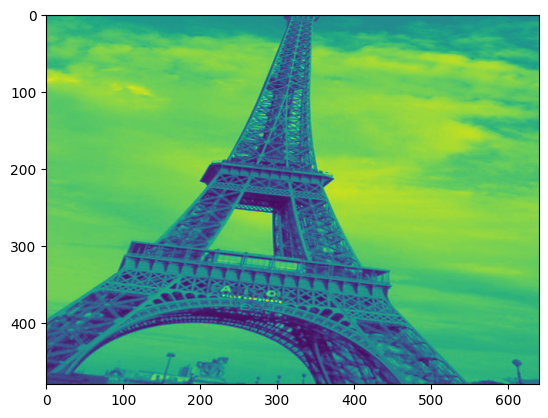

In [128]:
# path = 'mini_depth_100'
# image_path = 'mini_depth_100/138408872_2f903a81d4_o.jpg'
# generate sample homographies for images in path
import math

image_path = '/home/egoedeke/Downloads/MegaDepth_v1/phoenix/S6/zl548/MegaDepth_v1/0000/dense1/imgs/11037727_d36d4462ad_o.jpg'
#image = Image.open(image_path)

image = read_image(image_path, True)

height, width = image.shape[:2]
import matplotlib.pyplot as plt
# get image shape in h and w

conf = {
    "patch_shape": [640, 480],
    "difficulty": 0.5,
    "translation": 1.0,
    "n_angles": 10,
    "max_angle": 60,
    "min_convexity": 0.05,
}

# create a list of 10 warped images including the original image
# 10 images are created by applying a homography to the original image

sp_conf = {
    "max_num_keypoints": 500,
    "nms_radius": 4,
    "detection_threshold": 0.005,
    "remove_borders": 4,
    "descriptor_dim": 256,
    "channels": [64, 64, 128, 128, 256],
    "dense_outputs": None,
    "weights": None,  # local path of pretrained weights
}


model = SuperPoint(sp_conf)
model.eval()



image_with_homography = sample_homography(read_image(image_path, True), conf, [640, 480])
plt.imshow(image_with_homography['image'])    

a = sample_homography(read_image(image_path, True), conf, [640, 480])


imageh = a['image']
# visualize a

plt.imshow(a['image'])

The image size is: 
640 480


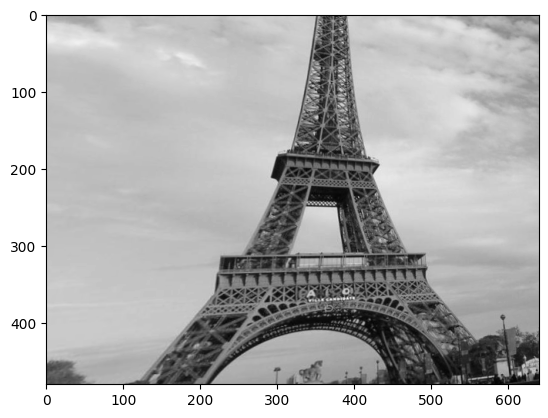

In [116]:
# path = 'mini_depth_100'
# image_path = 'mini_depth_100/138408872_2f903a81d4_o.jpg'
# generate sample homographies for images in path
#from PIL import Image
import math
import cv2
import matplotlib.pyplot as plt



# get dimensions of imageh
height, width = imageh.shape[:2]

# print image dimension
print('The image size is: ')
print(width, height)

#image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


# show gray
plt.imshow(imageh, cmap='gray')
plt.show()

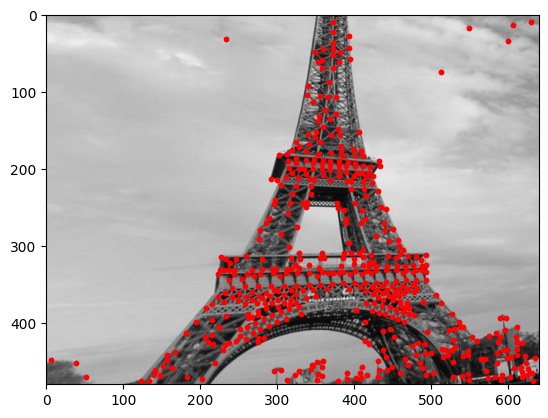

In [117]:
with torch.no_grad():
    # Get predictions from the model
    pred = model({"image": numpy_image_to_torch(imageh)[None]})
    # Move predictions to CPU and convert to numpy arrays
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    keypoints = pred["keypoints"]
    scores = pred["keypoint_scores"]
    descriptors = pred["descriptors"]
    
# Show keypoints
plt.imshow(imageh, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, c='r')

In [106]:
# warp_points
def warp_points(points, homography, inverse=True):
    """
    Warp a list of points with the INVERSE of the given homography.
    The inverse is used to be coherent with tf.contrib.image.transform
    Arguments:
        points: list of N points, shape (N, 2).
        homography: batched or not (shapes (B, 3, 3) and (3, 3) respectively).
    Returns: a Tensor of shape (N, 2) or (B, N, 2) (depending on whether the homography
            is batched) containing the new coordinates of the warped points.
    """
    H = homography[None] if len(homography.shape) == 2 else homography

    # Get the points to the homogeneous format
    num_points = points.shape[0]
    # points = points.astype(np.float32)[:, ::-1]
    points = np.concatenate([points, np.ones([num_points, 1], dtype=np.float32)], -1)

    H_inv = np.transpose(np.linalg.inv(H) if inverse else H)
    warped_points = np.tensordot(points, H_inv, axes=[[1], [0]])

    warped_points = np.transpose(warped_points, [2, 0, 1])
    warped_points[np.abs(warped_points[:, :, 2]) < 1e-8, 2] = 1e-8
    warped_points = warped_points[:, :, :2] / warped_points[:, :, 2:]

    return warped_points[0] if len(homography.shape) == 2 else warped_points


def warp_points_torch(points, H, inverse=True):
    """
    Warp a list of points with the INVERSE of the given homography.
    The inverse is used to be coherent with tf.contrib.image.transform
    Arguments:
        points: batched list of N points, shape (B, N, 2).
        H: batched or not (shapes (B, 3, 3) and (3, 3) respectively).
        inverse: Whether to multiply the points by H or the inverse of H
    Returns: a Tensor of shape (B, N, 2) containing the new coordinates of the warps.
    """

    # Get the points to the homogeneous format
    points = to_homogeneous(points)

    # Apply the homography
    H_mat = (torch.inverse(H) if inverse else H).transpose(-2, -1)
    warped_points = torch.einsum("...nj,...ji->...ni", points, H_mat)

    warped_points = from_homogeneous(warped_points, eps=1e-5)
    return warped_points


    

In [50]:
import numpy as np
from skimage import measure as skmeasure
import collections.abc as collections
import torch
import cv2

string_classes = str

def map_tensor(input_, func):
    if isinstance(input_, torch.Tensor):
        return func(input_)
    elif isinstance(input_, string_classes):
        return input_
    elif isinstance(input_, collections.Mapping):
        return {k: map_tensor(sample, func) for k, sample in input_.items()}
    elif isinstance(input_, collections.Sequence):
        return [map_tensor(sample, func) for sample in input_]
    else:
        raise TypeError(
            f'input must be tensor, dict or list; found {type(input_)}')


def batch_to_numpy(batch):
    return map_tensor(batch, lambda tensor: tensor.cpu().numpy())


def batch_to_device(batch, device, non_blocking=False):
    def _func(tensor):
        return tensor.to(device=device, non_blocking=non_blocking)

    return map_tensor(batch, _func)


def create_pairwise_conv_kernel(kernel_size,
                                center_size=16,
                                dia_stride=4,
                                random_dia=False, random_tot_1=1024,
                                return_neiCnt=False, diff_kernel=True):
    '''
    @func: create 1 x fH x fW x num_ch kernel for conv2D to compute pairwise-diff
    @param: kernel_size --[filter_ht, filter_wd]
            center_size -- scalar, neighbours in this window is all considered.
            dia_stride -- scalar, consider dialated pairs on further sides.
            random_dia -- perform random choice to assign neighbour
            random_tot_1 -- # of 1 in random result
            return_neiCnt -- return # of selected neighbour
    '''
    # selected neighbours for computing pairwise difference
    selected_neiI  = np.zeros(kernel_size)
    axis_x, axis_y = np.meshgrid(range(kernel_size[1]), range(kernel_size[0]))
    cy, cx         = kernel_size[0]//2, kernel_size[1]//2
    dist_mat_x     = np.abs(axis_x-cx)
    dist_mat_y     = np.abs(axis_y-cy)
    selected_neiI[(dist_mat_x+dist_mat_y)<center_size] = 1
    if random_dia == False:
        flagI = (np.mod(dist_mat_x, dia_stride) + np.mod(dist_mat_y, dia_stride)) == 0
        #flagI = (np.mod(dist_mat_x+dist_mat_y, dia_stride)==0)
        selected_neiI[flagI] = 1
    else:
        prob_1 = float(random_tot_1) / (kernel_size[0]*kernel_size[1])
        np.random.seed(17929104)
        random_neiI = np.random.choice([0,1], size=kernel_size, p=[1-prob_1, prob_1])
        selected_neiI[random_neiI==1] = 1
    selected_neiI[cy, cx:] = 1
    selected_neiI[cy:, cx] = 1
    selected_neiI[cy, cx]  = 0

    # label each neighbour with continuous indices
    identity_label = axis_y * kernel_size[1] + axis_x
    selected_neiI  = identity_label * selected_neiI

    # remove duplicate pairwise
    selected_neiI[:cy, :]       = 0
    selected_neiI[:cy+1, :cx+1] = 0

    # convert to one hot kernel
    label_neiI = skmeasure.label(selected_neiI)
    label_neiI = np.reshape(label_neiI, [-1])
    kernel     = np.eye(label_neiI.max()+1)[label_neiI]
    kernel     = np.reshape(kernel, [1, kernel_size[0], kernel_size[1], -1])

    if diff_kernel:
        kernel     = 0 - kernel[..., 1:]
        kernel[0, cy, cx, :] = 1

    if return_neiCnt:
        return kernel, label_neiI.max()
    else:
        return kernel


def check_nan_or_inf(t):
    return torch.any(find_nan_or_inf(t))


def find_nan_or_inf(t):
    return torch.logical_or(torch.isnan(t), torch.isinf(t))


def dot(a, b, dim=-1):
    """ Dot product of a and b along the specified dimension. """
    return (a * b).sum(dim)


def bilinear_interpolate_numpy(im, x, y):
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1] - 1)
    x1 = np.clip(x1, 0, im.shape[1] - 1)
    y0 = np.clip(y0, 0, im.shape[0] - 1)
    y1 = np.clip(y1, 0, im.shape[0] - 1)

    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return (Ia.T * wa).T + (Ib.T * wb).T + (Ic.T * wc).T + (Id.T * wd).T


def nn_interpolate_numpy(img, x, y):
    xi = np.clip(np.round(x).astype(int), 0, img.shape[1] - 1)
    yi = np.clip(np.round(y).astype(int), 0, img.shape[0] - 1)
    return img[yi, xi]


def compute_image_grad(img, ksize=7):
    blur_img = cv2.GaussianBlur(img, (ksize, ksize), 1).astype(np.float32)
    dx = np.zeros_like(blur_img)
    dy = np.zeros_like(blur_img)
    dx[:, 1:] = (blur_img[:, 1:] - blur_img[:, :-1]) / 2
    dx[1:, 1:] = dx[:-1, 1:] + dx[1:, 1:]
    dy[1:] = (blur_img[1:] - blur_img[:-1]) / 2
    dy[1:, 1:] = dy[1:, :-1] + dy[1:, 1:]
    gradnorm = np.sqrt(dx ** 2 + dy ** 2)
    gradangle = np.arctan2(dy, dx)
    return dx, dy, gradnorm, gradangle


def align_with_grad_angle(angle, img):
    """ Starting from an angle in [0, pi], find the sign of the angle based on
        the image gradient of the corresponding pixel. """
    # Image gradient
    img_grad_angle = compute_image_grad(img)[3]
    
    # Compute the distance of the image gradient to the angle
    # and angle - pi
    pred_grad = np.mod(angle, np.pi)  # in [0, pi]
    pos_dist = np.minimum(np.abs(img_grad_angle - pred_grad),
                          2 * np.pi - np.abs(img_grad_angle - pred_grad))
    neg_dist = np.minimum(
        np.abs(img_grad_angle - pred_grad + np.pi),
        2 * np.pi - np.abs(img_grad_angle - pred_grad + np.pi))
    
    # Assign the new grad angle to the closest of the two
    is_pos_closest = np.argmin(np.stack([neg_dist, pos_dist],
                                        axis=-1), axis=-1).astype(bool)
    new_grad_angle = np.where(is_pos_closest, pred_grad, pred_grad - np.pi)
    return new_grad_angle, img_grad_angle


def preprocess_angle(angle, img, mask=False):
    """ Convert a grad angle field into a line level angle, using
        the image gradient to get the right orientation. """
    oriented_grad_angle, img_grad_angle = align_with_grad_angle(angle, img)
    oriented_grad_angle = np.mod(oriented_grad_angle - np.pi / 2, 2 * np.pi)
    if mask:
        oriented_grad_angle[0] = -1024
        oriented_grad_angle[:, 0] = -1024
    return oriented_grad_angle.astype(np.float64), img_grad_angle

In [51]:
import numpy as np


def sample_homography(
        shape, perspective=True, scaling=True, rotation=True,
        translation=True, n_scales=5, n_angles=25, scaling_amplitude=0.1,
        perspective_amplitude_x=0.1, perspective_amplitude_y=0.1,
        patch_ratio=0.5, max_angle=1.57, allow_artifacts=False,
        translation_overflow=0.):
    """ Computes the homography transformation from a random patch in the
        original image to a warped projection with the same image size. The
        original patch, which is initialized with a simple half-size centered
        crop, is iteratively projected, scaled, rotated and translated.

    Args:
        shape: A tuple specifying the height and width of the original image.
        perspective: A boolean that enables the perspective and affine transformations.
        scaling: A boolean that enables the random scaling of the patch.
        rotation: A boolean that enables the random rotation of the patch.
        translation: A boolean that enables the random translation of the patch.
        n_scales: The number of tentative scales that are sampled when scaling.
        n_angles: The number of tentatives angles that are sampled when rotating.
        scaling_amplitude: Controls the amount of scale.
        perspective_amplitude_x: Controls the perspective effect in x direction.
        perspective_amplitude_y: Controls the perspective effect in y direction.
        patch_ratio: Controls the size of the patches used to create the homography.
        max_angle: Maximum angle used in rotations.
        allow_artifacts: A boolean that enables artifacts when applying the homography.
        translation_overflow: Amount of border artifacts caused by translation.

    Returns:
        An np.array of shape `[3, 3]` corresponding to the homography.
    """
    # Convert shape to ndarry
    if not isinstance(shape, np.ndarray):
        shape = np.array(shape)

    # Corners of the output patch
    margin = (1 - patch_ratio) / 2
    pts1 = margin + np.array([[0, 0], [0, patch_ratio],
                             [patch_ratio, patch_ratio], [patch_ratio, 0]])
    # Corners of the intput image
    pts2 = pts1.copy()

    # Random perspective and affine perturbations
    if perspective:
        if not allow_artifacts:
            perspective_amplitude_x = min(perspective_amplitude_x, margin)
            perspective_amplitude_y = min(perspective_amplitude_y, margin)

        # normal distribution with mean=0, std=perspective_amplitude_y/2
        perspective_displacement = np.random.normal(
            0., perspective_amplitude_y/2, [1])
        h_displacement_left = np.random.normal(0., perspective_amplitude_x/2,
                                               [1])
        h_displacement_right = np.random.normal(0., perspective_amplitude_x/2,
                                                [1])
        pts2 += np.stack([np.concatenate([h_displacement_left,
                                          perspective_displacement], 0),
                          np.concatenate([h_displacement_left,
                                          -perspective_displacement], 0),
                          np.concatenate([h_displacement_right,
                                          perspective_displacement], 0),
                          np.concatenate([h_displacement_right,
                                          -perspective_displacement], 0)])

    # Random scaling: sample several scales, check collision with borders,
    # randomly pick a valid one
    if scaling:
        scales = np.concatenate(
            [[1.], np.random.normal(1, scaling_amplitude/2, [n_scales])], 0)
        center = np.mean(pts2, axis=0, keepdims=True)
        scaled = (pts2 - center)[None, ...] * scales[..., None, None] + center
        # all scales are valid except scale=1
        if allow_artifacts:
            valid = np.arange(n_scales)
        else:
            valid = np.where(np.all((scaled >= 0.) & (scaled < 1.), (1, 2)))[0]
        idx = valid[np.random.uniform(0., valid.shape[0], ()).astype(np.int32)]
        pts2 = scaled[idx]

    # Random translation
    if translation:
        t_min, t_max = np.min(pts2, axis=0), np.min(1 - pts2, axis=0)
        if allow_artifacts:
            t_min += translation_overflow
            t_max += translation_overflow
        pts2 += (np.stack([np.random.uniform(-t_min[0], t_max[0], ()),
                           np.random.uniform(-t_min[1], t_max[1], ())]))[None, ...]

    # Random rotation: sample several rotations, check collision with borders,
    # randomly pick a valid one
    if rotation:
        angles = np.linspace(-max_angle, max_angle, n_angles)
        # in case no rotation is valid
        angles = np.concatenate([[0.], angles], axis=0)
        center = np.mean(pts2, axis=0, keepdims=True)
        rot_mat = np.reshape(np.stack(
            [np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)],
            axis=1), [-1, 2, 2])
        rotated = np.matmul(
                np.tile((pts2 - center)[None, ...], [n_angles+1, 1, 1]),
                rot_mat) + center
        if allow_artifacts:
            valid = np.array(range(n_angles))  # all angles are valid, except angle=0
        else:
            valid = np.where(np.all((rotated >= 0.) & (rotated < 1.), axis=(1, 2)))[0]
        idx = valid[np.random.uniform(0., valid.shape[0], ()).astype(np.int32)]
        pts2 = rotated[idx]

    # Rescale to actual size
    shape = shape[::-1].astype(np.float32)  # different convention [y, x]
    pts1 *= shape[None, ...]
    pts2 *= shape[None, ...]

    def ax(p, q): return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]

    def ay(p, q): return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

    a_mat = np.stack([f(pts1[i], pts2[i]) for i in range(4) for f in (ax, ay)], axis=0)
    p_mat = np.transpose(np.stack([[pts2[i][j] for i in range(4) for j in range(2)]], axis=0))
    homo_vec, _, _, _ = np.linalg.lstsq(a_mat, p_mat, rcond=None)

    # Compose the homography vector back to matrix
    homo_mat = np.concatenate([homo_vec[0:3, 0][None, ...],
                                homo_vec[3:6, 0][None, ...],
                                np.concatenate((homo_vec[6], homo_vec[7], [1]),
                                axis=0)[None, ...]], axis=0)

    return homo_mat


def warp_points(points, H):
    """ Warp 2D points by an homography H. """
    n_points = points.shape[0]
    reproj_points = points.copy()[:, [1, 0]]
    reproj_points = np.concatenate([reproj_points, np.ones((n_points, 1))],
                                   axis=1)
    reproj_points = H.dot(reproj_points.transpose()).transpose()
    reproj_points = reproj_points[:, :2] / reproj_points[:, 2:]
    reproj_points = reproj_points[:, [1, 0]]
    return reproj_points


def warp_lines(lines, H):
    """ Warp lines of the shape [N, 2, 2] by an homography H. """
    return warp_points(lines.reshape(-1, 2), H).reshape(-1, 2, 2)

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VGGUNet(torch.nn.Module):
    def __init__(self, tiny=False):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        if tiny:
            sizes = [32, 64, 128, 256]
        else:
            sizes = [64, 128, 256, 512]
        
        # Encoder blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(1, sizes[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[0]),
            nn.Conv2d(sizes[0], sizes[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[0]),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(sizes[0], sizes[1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[1]),
            nn.Conv2d(sizes[1], sizes[1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[1]),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(sizes[1], sizes[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[2]),
            nn.Conv2d(sizes[2], sizes[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[2]),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(sizes[2], sizes[3], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[3]),
            nn.Conv2d(sizes[3], sizes[3], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[3]),
        )

        # Decoder blocks
        self.deblock4 = nn.Sequential(
            nn.Conv2d(sizes[3], sizes[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[2]),
            nn.Conv2d(sizes[2], sizes[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[2]),
        )
        self.deblock3 = nn.Sequential(
            nn.Conv2d(sizes[3], sizes[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[2]),
            nn.Conv2d(sizes[2], sizes[1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[1]),
        )
        self.deblock2 = nn.Sequential(
            nn.Conv2d(sizes[2], sizes[1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[1]),
            nn.Conv2d(sizes[1], sizes[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[0]),
        )
        self.deblock1 = nn.Sequential(
            nn.Conv2d(sizes[1], sizes[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[0]),
            nn.Conv2d(sizes[0], sizes[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(sizes[0]),
        )

    def forward(self, inputs):
        # Encoding
        features = [self.block1(inputs)]
        for block in [self.block2, self.block3, self.block4]:
            features.append(block(self.pool(features[-1])))

        # Decoding
        out = self.deblock4(features[-1])
        for deblock, feat in zip(
            [self.deblock3, self.deblock2, self.deblock1], features[:-1][::-1]):
            out = deblock(torch.cat([
                F.interpolate(out, feat.shape[2:4], mode='bilinear'),
                feat], dim=1))

        return out  # dim = 32 if tiny else 64

In [53]:
"""
    A set of geometry tools to handle lines in Pytorch and Numpy.
"""

import numpy as np
import cv2
import torch
import numpy as np
import torch.nn.functional as F
from scipy.sparse.csgraph import connected_components

# from ..datasets.utils.homographies import warp_lines
# from ..utils.tensor import (nn_interpolate_numpy, bilinear_interpolate_numpy,  compute_image_grad, preprocess_angle)


UPM_EPS = 1e-8

### Gradient computation

def compute_gradient_torch(img):
    """ Compute the x and y components of the gradient of a torch image. """
    if isinstance(img, torch.Tensor):
        torch_img = img.clone()
    else:
        torch_img = torch.tensor(img, dtype=torch.float)
    img_size = torch_img.shape
    device = torch_img.device
    if len(img_size) == 2:
        torch_img = torch_img[None, None]
    if len(img_size) == 3:
        torch_img = torch_img[:, None]
    x_kernel = torch.tensor([[-1, 1], [-1, 1]], dtype=torch.float,
                            device=device)[None, None]
    y_kernel = torch.tensor([[-1, -1], [1, 1]], dtype=torch.float,
                            device=device)[None, None]
    grad_x = F.conv2d(torch_img, x_kernel, padding=1)[:, :, 1:, 1:]
    grad_y = F.conv2d(torch_img, y_kernel, padding=1)[:, :, 1:, 1:]
    return [grad_x / .2, grad_y / .2]
    
    
def compute_line_level_torch(img):
    """ Compute the orientation and magnitude of the line level
        (orthogonal to the gradient), after smoothing the image. """
    # Smooth the image
    kernel = cv2.getGaussianKernel(7, 0.6)
    kernel = torch.tensor(np.outer(kernel, kernel), dtype=torch.float,
                          device=img.device)[None, None]
    img = F.conv2d(F.pad(img, (3, 3, 3, 3), 'reflect'), kernel)
    
    # Compute the gradient and line-level orientation
    grad_x, grad_y = compute_gradient_torch(img)
    grad_norm = torch.sqrt(grad_x * grad_x + grad_y * grad_y)
    line_level_ang = torch.atan2(grad_x, -grad_y)
    return line_level_ang, grad_norm


### Line segment distances

def absolute_angle_distance(a0, a1):
    """ Compute the absolute distance between two angles, modulo pi.
        a0 and a1 are two angles in [-pi, +pi]. """
    pi_torch = torch.tensor(np.pi, device=a0.device)
    diff = torch.fmod(torch.abs(a0 - a1), pi_torch)
    return torch.min(diff, pi_torch - diff)


def get_structural_line_dist(warped_ref_line_seg, target_line_seg):
    """ Compute the distances between two sets of lines
        using the structural distance. """
    dist = (((warped_ref_line_seg[:, None, :, None]
              - target_line_seg[:, None]) ** 2).sum(-1)) ** 0.5
    dist = np.minimum(
        dist[:, :, 0, 0] + dist[:, :, 1, 1],
        dist[:, :, 0, 1] + dist[:, :, 1, 0]
    ) / 2
    return dist


def project_point_to_line(line_segs, points):
    """ Given a list of line segments and a list of points (2D or 3D coordinates),
        compute the orthogonal projection of all points on all lines.
        This returns the 1D coordinates of the projection on the line,
        as well as the list of orthogonal distances. """
    # Compute the 1D coordinate of the points projected on the line
    dir_vec = (line_segs[:, 1] - line_segs[:, 0])[:, None]
    coords1d = (((points[None] - line_segs[:, None, 0]) * dir_vec).sum(axis=2)
                / np.linalg.norm(dir_vec, axis=2) ** 2)
    # coords1d is of shape (n_lines, n_points)
    
    # Compute the orthogonal distance of the points to each line
    projection = line_segs[:, None, 0] + coords1d[:, :, None] * dir_vec
    dist_to_line = np.linalg.norm(projection - points[None], axis=2)

    return coords1d, dist_to_line


def get_segment_overlap(seg_coord1d):
    """ Given a list of segments parameterized by the 1D coordinate
        of the endpoints, compute the overlap with the segment [0, 1]. """
    seg_coord1d = np.sort(seg_coord1d, axis=-1)
    overlap = ((seg_coord1d[..., 1] > 0) * (seg_coord1d[..., 0] < 1)
               * (np.minimum(seg_coord1d[..., 1], 1)
                  - np.maximum(seg_coord1d[..., 0], 0)))
    return overlap


def get_orth_line_dist(line_seg1, line_seg2, min_overlap=0.5,
                       return_overlap=False, mode='min'):
    """ Compute the symmetrical orthogonal line distance between two sets
        of lines and the average overlapping ratio of both lines.
        Enforce a high line distance for small overlaps.
        This is compatible for nD objects (e.g. both lines in 2D or 3D). """
    n_lines1, n_lines2 = len(line_seg1), len(line_seg2)

    # Compute the average orthogonal line distance
    coords_2_on_1, line_dists2 = project_point_to_line(
        line_seg1, line_seg2.reshape(n_lines2 * 2, -1))
    line_dists2 = line_dists2.reshape(n_lines1, n_lines2, 2).sum(axis=2)
    coords_1_on_2, line_dists1 = project_point_to_line(
        line_seg2, line_seg1.reshape(n_lines1 * 2, -1))
    line_dists1 = line_dists1.reshape(n_lines2, n_lines1, 2).sum(axis=2)
    line_dists = (line_dists2 + line_dists1.T) / 2

    # Compute the average overlapping ratio
    coords_2_on_1 = coords_2_on_1.reshape(n_lines1, n_lines2, 2)
    overlaps1 = get_segment_overlap(coords_2_on_1)
    coords_1_on_2 = coords_1_on_2.reshape(n_lines2, n_lines1, 2)
    overlaps2 = get_segment_overlap(coords_1_on_2).T
    overlaps = (overlaps1 + overlaps2) / 2
    min_overlaps = np.minimum(overlaps1, overlaps2)
    
    if return_overlap:
        return line_dists, overlaps

    # Enforce a max line distance for line segments with small overlap
    if mode == 'mean':
        low_overlaps = overlaps < min_overlap
    else:
        low_overlaps = min_overlaps < min_overlap
    line_dists[low_overlaps] = np.amax(line_dists)
    return line_dists


def angular_distance(segs1, segs2):
    """ Compute the angular distance (via the cosine similarity)
        between two sets of line segments. """
    # Compute direction vector of segs1
    dirs1 = segs1[:, 1] - segs1[:, 0]
    dirs1 /= (np.linalg.norm(dirs1, axis=1, keepdims=True) + UPM_EPS)
    # Compute direction vector of segs2
    dirs2 = segs2[:, 1] - segs2[:, 0]
    dirs2 /= (np.linalg.norm(dirs2, axis=1, keepdims=True) + UPM_EPS)
    # https://en.wikipedia.org/wiki/Cosine_similarity
    return np.arccos(np.minimum(1, np.abs(np.einsum('ij,kj->ik', dirs1, dirs2))))


def overlap_distance_asym(line_seg1, line_seg2):
    """ Compute the overlap distance of line_seg2 projected to line_seg1. """
    n_lines1, n_lines2 = len(line_seg1), len(line_seg2)

    # Project endpoints 2 onto lines 1
    coords_2_on_1, _ = project_point_to_line(
        line_seg1, line_seg2.reshape(n_lines2 * 2, 2))
    coords_2_on_1 = coords_2_on_1.reshape(n_lines1, n_lines2, 2)

    # Compute the overlap
    overlaps = get_segment_overlap(coords_2_on_1)
    return overlaps


def overlap_distance_sym(line_seg1, line_seg2):
    """ Compute the symmetric overlap distance of line_seg2 and line_seg1. """
    overlap_2_on_1 = overlap_distance_asym(line_seg1, line_seg2)
    overlap_1_on_2 = overlap_distance_asym(line_seg2, line_seg1).T
    return (overlap_2_on_1 + overlap_1_on_2) / 2


def orientation(p, q, r):
    """ Compute the orientation of a list of triplets of points. """
    return np.sign((q[:, 1] - p[:, 1]) * (r[:, 0] - q[:, 0])
                   - (q[:, 0] - p[:, 0]) * (r[:, 1] - q[:, 1]))


def is_on_segment(line_seg, p):
    """ Check whether a point p is on a line segment, assuming the point
        to be colinear with the two endpoints. """
    return ((p[:, 0] >= np.min(line_seg[:, :, 0], axis=1))
            & (p[:, 0] <= np.max(line_seg[:, :, 0], axis=1))
            & (p[:, 1] >= np.min(line_seg[:, :, 1], axis=1))
            & (p[:, 1] <= np.max(line_seg[:, :, 1], axis=1)))


def intersect(line_seg1, line_seg2):
    """ Check whether two sets of lines segments
        intersects with each other. """
    ori1 = orientation(line_seg1[:, 0], line_seg1[:, 1], line_seg2[:, 0])
    ori2 = orientation(line_seg1[:, 0], line_seg1[:, 1], line_seg2[:, 1])
    ori3 = orientation(line_seg2[:, 0], line_seg2[:, 1], line_seg1[:, 0])
    ori4 = orientation(line_seg2[:, 0], line_seg2[:, 1], line_seg1[:, 1])
    return (((ori1 != ori2) & (ori3 != ori4))
            | ((ori1 == 0) & is_on_segment(line_seg1, line_seg2[:, 0]))
            | ((ori2 == 0) & is_on_segment(line_seg1, line_seg2[:, 1]))
            | ((ori3 == 0) & is_on_segment(line_seg2, line_seg1[:, 0]))
            | ((ori4 == 0) & is_on_segment(line_seg2, line_seg1[:, 1])))


def get_area_line_dist_asym(line_seg1, line_seg2, lbd=1/24):
    """ Compute an asymmetric line distance function which is not biased by
        the line length and is based on the area between segments.
        Here, line_seg2 are projected to the infinite line of line_seg1. """
    n1, n2 = len(line_seg1), len(line_seg2)

    # Determine which segments are intersecting each other
    all_line_seg1 = line_seg1[:, None].repeat(n2, axis=1).reshape(n1 * n2,
                                                                  2, 2)
    all_line_seg2 = line_seg2[None].repeat(n1, axis=0).reshape(n1 * n2, 2, 2)
    are_crossing = intersect(all_line_seg1, all_line_seg2)  # [n1 * n2]
    are_crossing = are_crossing.reshape(n1, n2)

    # Compute the orthogonal distance of the endpoints of line_seg2
    orth_dists2 = project_point_to_line(
        line_seg1, line_seg2.reshape(n2 * 2, 2))[1].reshape(n1, n2, 2)

    # Compute the angle between the line segments
    theta = angular_distance(line_seg1, line_seg2)  # [n1, n2]
    parallel = np.abs(theta) < 1e-8

    # Compute the orthogonal distance of the closest endpoint of line_seg2
    T = orth_dists2.min(axis=2)  # [n1, n2]

    # The distance for the intersecting lines is the area of two triangles,
    # divided by the length of line_seg2 squared:
    # area_dist = (d1^2+d2^2)/(2*tan(theta)*l^2)
    tan_theta = np.tan(theta)
    tan_theta[parallel] = 1
    length2 = np.linalg.norm(all_line_seg2[:, 0] - all_line_seg2[:, 1],
                             axis=1).reshape(n1, n2)
    area_dist = ((orth_dists2 ** 2).sum(axis=2)
                 / (2 * tan_theta * length2 ** 2) * (1. - parallel))

    # The distance for the non intersecting lines is lbd*T+1/4*sin(2*theta)
    non_int_area_dist = lbd * T + 1/4 * np.sin(2 * theta)
    area_dist[~are_crossing] = non_int_area_dist[~are_crossing]

    return area_dist


def get_area_line_dist(line_seg1, line_seg2, lbd=1/24):
    """ Compute a fairer line distance function which is not biased by
        the line length and is based on the area between segments. """
    area_dist_2_on_1 = get_area_line_dist_asym(line_seg1, line_seg2, lbd)
    area_dist_1_on_2 = get_area_line_dist_asym(line_seg2, line_seg1, lbd)
    area_dist = (area_dist_2_on_1 + area_dist_1_on_2.T) / 2
    return area_dist


def get_lip_line_dist_asym(line_seg1, line_seg2, default_len=30):
    """ Compute an asymmetrical length-invariant perpendicular distance. """
    n1, n2 = len(line_seg1), len(line_seg2)

    # Determine which segments are intersecting each other
    all_line_seg1 = line_seg1[:, None].repeat(n2, axis=1).reshape(n1 * n2,
                                                                  2, 2)
    all_line_seg2 = line_seg2[None].repeat(n1, axis=0).reshape(n1 * n2, 2, 2)
    are_crossing = intersect(all_line_seg1, all_line_seg2)  # [n1 * n2]
    are_crossing = are_crossing.reshape(n1, n2)

    # Compute the angle difference
    theta = angular_distance(line_seg1, line_seg2)  # [n1, n2]

    # Compute the orthogonal distance of the closest endpoint of line_seg2
    orth_dists2 = project_point_to_line(
        line_seg1, line_seg2.reshape(n2 * 2, 2))[1].reshape(n1, n2, 2)
    T = orth_dists2.min(axis=2)  # [n1, n2]
    
    # The distance is default_len * sin(theta) / 2 for intersecting lines
    # and T + default_len * sin(theta) / 2 for non intersecting ones
    # This means that a line crossing with theta=30deg is equivalent to a
    # parallel line with an offset T = default_len / 4
    lip_dist = default_len * np.sin(theta) / 2
    lip_dist[~are_crossing] += T[~are_crossing]
    return lip_dist


def get_lip_line_dist(line_seg1, line_seg2):
    """ Compute a length-invariant perpendicular distance. """
    lip_dist_2_on_1 = get_lip_line_dist_asym(line_seg1, line_seg2)
    lip_dist_1_on_2 = get_lip_line_dist_asym(line_seg2, line_seg1)
    lip_dist = (lip_dist_2_on_1 + lip_dist_1_on_2.T) / 2
    return lip_dist


### Line pre and post-processing

def clip_line_to_boundary(lines):
    """ Clip the first coordinate of a set of lines to the lower boundary 0
        and indicate which lines are completely outside of the boundary.
    Args:
        lines: a [N, 2, 2] tensor of lines.
    Returns:
        The clipped coordinates + a mask indicating invalid lines.
    """
    updated_lines = lines.copy()
    
    # Detect invalid lines completely outside of the first boundary
    invalid = np.all(lines[:, :, 0] < 0, axis=1)
    
    # Clip the lines to the boundary and update the second coordinate
    # First endpoint
    out = lines[:, 0, 0] < 0
    denom = lines[:, 1, 0] - lines[:, 0, 0]
    denom[denom == 0] = 1e-6
    ratio = lines[:, 1, 0] / denom
    updated_y = ratio * lines[:, 0, 1] + (1 - ratio) * lines[:, 1, 1]
    updated_lines[out, 0, 1] = updated_y[out]
    updated_lines[out, 0, 0] = 0
    # Second endpoint
    out = lines[:, 1, 0] < 0
    denom = lines[:, 0, 0] - lines[:, 1, 0]
    denom[denom == 0] = 1e-6
    ratio = lines[:, 0, 0] / denom
    updated_y = ratio * lines[:, 1, 1] + (1 - ratio) * lines[:, 0, 1]
    updated_lines[out, 1, 1] = updated_y[out]
    updated_lines[out, 1, 0] = 0
    
    return updated_lines, invalid


def clip_line_to_boundaries(lines, img_size, min_len=10):
    """ Clip a set of lines to the image boundaries and indicate
        which lines are completely outside of the boundaries.
    Args:
        lines: a [N, 2, 2] tensor of lines.
        img_size: the original image size.
    Returns:
        The clipped coordinates + a mask indicating valid lines.
    """
    new_lines = lines.copy()
    
    # Clip the first coordinate to the 0 boundary of img1
    new_lines, invalid_x0 = clip_line_to_boundary(lines)
    
    # Mirror in first coordinate to clip to the H-1 boundary
    new_lines[:, :, 0] = img_size[0] - 1 - new_lines[:, :, 0]
    new_lines, invalid_xh = clip_line_to_boundary(new_lines)
    new_lines[:, :, 0] = img_size[0] - 1 - new_lines[:, :, 0]
    
    # Swap the two coordinates, perform the same for y, and swap back
    new_lines = new_lines[:, :, [1, 0]]
    new_lines, invalid_y0 = clip_line_to_boundary(new_lines)
    new_lines[:, :, 0] = img_size[1] - 1 - new_lines[:, :, 0]
    new_lines, invalid_yw = clip_line_to_boundary(new_lines)
    new_lines[:, :, 0] = img_size[1] - 1 - new_lines[:, :, 0]
    new_lines = new_lines[:, :, [1, 0]]
    
    # Merge all the invalid lines and also remove lines that became too short
    short = np.linalg.norm(new_lines[:, 1] - new_lines[:, 0],
                           axis=1) < min_len
    valid = np.logical_not(invalid_x0 | invalid_xh
                           | invalid_y0 | invalid_yw | short)
    
    return new_lines, valid


def get_common_lines(lines0, lines1, H, img_size):
    """ Extract the lines in common between two views, by warping lines1
        into lines0 frame.
    Args:
        lines0, lines1: sets of lines of size [N, 2, 2].
        H: homography relating the lines.
        img_size: size of the original images img0 and img1.
    Returns:
        Updated lines0 with a valid reprojection in img1 and warped_lines1.
    """
    # First warp lines0 to img1 to detect invalid lines
    warped_lines0 = warp_lines(lines0, H)
    
    # Clip them to the boundary
    warped_lines0, valid = clip_line_to_boundaries(warped_lines0, img_size)
    
    # Warp all the valid lines back in img0
    inv_H = np.linalg.inv(H)
    new_lines0 = warp_lines(warped_lines0[valid], inv_H)
    warped_lines1 = warp_lines(lines1, inv_H)
    warped_lines1, valid = clip_line_to_boundaries(warped_lines1, img_size)

    return new_lines0, warped_lines1[valid]


def merge_line_cluster(lines):
    """ Merge a cluster of line segments.
    First compute the principal direction of the lines, compute the
    endpoints barycenter, project the endpoints onto the middle line,
    keep the two extreme projections.
    Args:
        lines: a (n, 2, 2) np array containing n lines.
    Returns:
        The merged (2, 2) np array line segment.
    """
    # Get the principal direction of the endpoints
    points = lines.reshape(-1, 2)
    weights = np.linalg.norm(lines[:, 0] - lines[:, 1], axis=1)
    weights = np.repeat(weights, 2)[:, None]
    weights /= weights.sum()  # More weights for longer lines
    avg_points = (points * weights).sum(axis=0)
    points_bar = points - avg_points[None]
    cov = 1 / 3 * np.einsum(
        'ij,ik->ijk', points_bar, points_bar * weights).sum(axis=0)
    a, b, c = cov[0, 0], cov[0, 1], cov[1, 1]
    # Principal component of a 2x2 symmetric matrix
    if b == 0:
        u = np.array([1, 0]) if a >= c else np.array([0, 1])
    else:
        m = (c - a + np.sqrt((a - c) ** 2 + 4 * b ** 2)) / (2 * b)
        u = np.array([1, m]) / np.sqrt(1 + m ** 2)
        
    # Get the center of gravity of all endpoints
    cross = np.mean(points, axis=0)
        
    # Project the endpoints on the line defined by cross and u
    avg_line_seg = np.stack([cross, cross + u], axis=0)
    proj = project_point_to_line(avg_line_seg[None], points)[0]
    
    # Take the two extremal projected endpoints
    new_line = np.stack([cross + np.amin(proj) * u,
                         cross + np.amax(proj) * u], axis=0)
    return new_line


def merge_lines(lines, thresh=5., overlap_thresh=0.):
    """ Given a set of lines, merge close-by lines together.
    Two lines are merged when their orthogonal distance is smaller
    than a threshold and they have a positive overlap.
    Args:
        lines: a (N, 2, 2) np array.
        thresh: maximum orthogonal distance between two lines to be merged.
        overlap_thresh: maximum distance between 2 endpoints to merge
                        two aligned lines.
    Returns:
        The new lines after merging.
    """
    if len(lines) == 0:
        return lines

    # Compute the pairwise orthogonal distances and overlap
    orth_dist, overlaps = get_orth_line_dist(lines, lines, return_overlap=True)
    
    # Define clusters of close-by lines to merge
    if overlap_thresh == 0:
        adjacency_mat = (overlaps > 0) * (orth_dist < thresh)
    else:
        # Filter using the distance between the two closest endpoints
        n = len(lines)
        endpoints = lines.reshape(n * 2, 2)
        close_endpoint = np.linalg.norm(endpoints[:, None] - endpoints[None],
                                        axis=2)
        close_endpoint = close_endpoint.reshape(n, 2, n, 2).transpose(
            0, 2, 1, 3).reshape(n, n, 4)
        close_endpoint = np.amin(close_endpoint, axis=2)
        adjacency_mat = (((overlaps > 0) | (close_endpoint < overlap_thresh))
                         * (orth_dist < thresh))
    n_comp, components = connected_components(adjacency_mat, directed=False)
    
    # For each cluster, merge all lines into a single one
    new_lines = []
    for i in range(n_comp):
        cluster = lines[components == i]
        new_lines.append(merge_line_cluster(cluster))
        
    return np.stack(new_lines, axis=0)


def filter_lines(lines, df, line_level, df_thresh=0.004, ang_thresh=0.383):
    """ Filter out lines that have an average DF value too high, or
    whose direction does not agree with the line level map.
    Args:
        lines: a (N, 2, 2) torch tensor.
        df, line_level: (rows, cols) tensors with the DF and line-level values.
        df_thresh, ang_thresh: threshold for the DF and line_level.
    Returns:
        A tuple with the filtered lines and a mask of valid lines.
    """
    n_samples = 10
    rows, cols = df.shape
    
    # DF check
    alpha = torch.linspace(0, 1, n_samples, device=df.device)[None]
    x_coord = 2 * (lines[:, :1, 1] * alpha
                   + lines[:, 1:, 1] * (1 - alpha)) / cols - 1
    y_coord = 2 * (lines[:, :1, 0] * alpha
                   + lines[:, 1:, 0] * (1 - alpha)) / rows - 1
    grid = torch.stack([x_coord, y_coord], dim=-1)[None]
    # grid is of size [1, num_lines, n_samples, 2]
    df_samples = F.grid_sample(df[None, None], grid, mode='bilinear',
                               padding_mode='border')[0, 0]
    df_check = df_samples.mean(dim=1) < df_thresh

    # Line orientation check
    line_len = torch.sqrt(((lines[:, 0] - lines[:, 1]) ** 2).sum(dim=1))
    vec_x = ((lines[:, 1, 1] - lines[:, 0, 1]) / line_len).unsqueeze(-1)
    vec_y = ((lines[:, 1, 0] - lines[:, 0, 0]) / line_len).unsqueeze(-1)
    cos_line_level = torch.cos(line_level)[None, None]
    sin_line_level = torch.sin(line_level)[None, None]
    cos_samples = F.grid_sample(cos_line_level, grid, mode='bilinear',
                                padding_mode='border')[0, 0]
    sin_samples = F.grid_sample(sin_line_level, grid, mode='bilinear',
                                padding_mode='border')[0, 0]
    ang_check = torch.abs(
        cos_samples * vec_y - sin_samples * vec_x).mean(dim=1) < ang_thresh
    
    # Gather the results
    valid = df_check & ang_check
    return lines[valid], valid


def filter_outlier_lines(
    img, lines, df, angle, mode='inlier_thresh', use_grad=False,
    inlier_thresh=0.5, df_thresh=1.5, ang_thresh=np.pi / 6, n_samples=50):
    """ Filter out outlier lines either by comparing the average DF and
        line level values to a threshold or by counting the number of inliers
        across the line. It can also optionally use the image gradient.
    Args:
        img: the original image.
        lines: a (N, 2, 2) np array.
        df: np array with the distance field.
        angle: np array with the grad angle field.
        mode: 'mean' or 'inlier_thresh'.
        use_grad: True to use the image gradient instead of line_level.
        inlier_thresh: ratio of inliers to get accepted.
        df_thresh, ang_thresh: thresholds to determine a valid value.
        n_samples: number of points sampled along each line.
    Returns:
        A tuple with the filtered lines and a mask of valid lines.
    """
    # Get the right orientation of the line_level and the lines orientation
    oriented_line_level, img_grad_angle = preprocess_angle(angle, img)
    orientations = get_line_orientation(lines, oriented_line_level)

    # Get the sample positions
    t = np.linspace(0, 1, n_samples)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the DF and angle map
    df_samples = bilinear_interpolate_numpy(df, samples[:, 1], samples[:, 0])
    df_samples = df_samples.reshape(-1, n_samples)
    if use_grad:
        oriented_line_level = np.mod(img_grad_angle - np.pi / 2, 2 * np.pi)
    ang_samples = nn_interpolate_numpy(oriented_line_level, samples[:, 1],
                                       samples[:, 0]).reshape(-1, n_samples)

    # Check the average value or number of inliers
    if mode == 'mean':
        df_check = np.mean(df_samples, axis=1) < df_thresh
        ang_avg = np.arctan2(np.sin(ang_samples).sum(axis=1),
                             np.cos(ang_samples).sum(axis=1))
        ang_diff = np.minimum(np.abs(ang_avg - orientations),
                              2 * np.pi - np.abs(ang_avg - orientations))
        ang_check = ang_diff < ang_thresh
        valid = df_check & ang_check
    elif mode == 'inlier_thresh':
        df_check = df_samples < df_thresh
        ang_diff = np.minimum(
            np.abs(ang_samples - orientations[:, None]),
            2 * np.pi - np.abs(ang_samples - orientations[:, None]))
        ang_check = ang_diff < ang_thresh
        valid = (df_check & ang_check).mean(axis=1) > inlier_thresh
    else:
        raise ValueError("Unknown filtering mode: " + mode)

    return lines[valid], valid


### DF-related methods

def seg_to_df(lines, img_size):
    """ Convert a list of lines into a distance field map in pixels.
    Compute also the point on the closest line.
    Args:
        lines: set of lines of size [N, 2, 2].
        img_size: the original image size (H, W).
    Returns:
        A tuple containing the following elements:
        - a 2D map of size (H, W) with the distance of each pixel
        to the closest line.
        - a [H, W, 2] array containing the closest point for each pixel.
        - a bool indicating if the closest point is an endpoint or not.
    """
    h, w = img_size
    diag_len = np.sqrt(h ** 2 + w ** 2)
    
    # Stop if no lines are present
    if len(lines) == 0:
        return (np.ones(img_size), np.zeros((h, w, 2)),
                np.ones(img_size, dtype=bool))

    # Get the pixel positions
    pix_loc = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    pix_loc = np.stack(pix_loc, axis=-1).reshape(-1, 2)
    
    # Compute their distance and angle to every line segment
    # Orthogonal line distance
    proj, dist = project_point_to_line(lines, pix_loc)
    out_seg = (proj < 0) | (proj > 1)
    dist[out_seg] = diag_len
    closest_on_line = np.argmin(dist, axis=0)
    closest_on_line = (lines[closest_on_line][:, 0]
                       + proj[closest_on_line, np.arange(len(pix_loc))][:, None]
                       * (lines[closest_on_line][:, 1]
                          - lines[closest_on_line][:, 0]))
    dist = np.amin(dist, axis=0)
    # Distance to the closest endpoint
    dist_e1 = np.linalg.norm(pix_loc[:, None] - lines[None, :, 0], axis=2)
    dist_e2 = np.linalg.norm(pix_loc[:, None] - lines[None, :, 1], axis=2)
    struct_dist = np.minimum(dist_e1, dist_e2)
    closest_on_endpoint = np.argmin(struct_dist, axis=1)
    endpoint_candidates = lines[closest_on_endpoint]
    closest_endpoint = np.argmin(
        np.stack([dist_e1[np.arange(len(pix_loc)), closest_on_endpoint],
                  dist_e2[np.arange(len(pix_loc)), closest_on_endpoint]],
                 axis=-1), axis=1)
    closest_on_endpoint = endpoint_candidates[np.arange(len(pix_loc)),
                                              closest_endpoint]
    struct_dist = np.amin(struct_dist, axis=1)
    # Take the minimum of the orthogonal line distance and endpoint distance
    is_closest_endpoint = struct_dist < dist
    dist = np.minimum(dist, struct_dist)
    closest_point = np.where(is_closest_endpoint[:, None], closest_on_endpoint,
                             closest_on_line)  
    
    # Reshape
    dist = dist.reshape(h, w)
    is_closest_endpoint = is_closest_endpoint.reshape(h, w)
    closest_point = closest_point.reshape(h, w, 2)
    return dist, closest_point, is_closest_endpoint


### General util functions

def sample_along_line(lines, img, n_samples=10, mode='mean'):
    """ Sample a fixed number of points along each line and interpolate
        an img at these points, and finally aggregate the values. """
    # Get the sample positions
    t = np.linspace(0, 1, 10)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the img at the samples and aggregate the values
    if mode == 'mean':
        # Average
        val = bilinear_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.mean(val.reshape(-1, n_samples), axis=-1)
    elif mode == 'angle':
        # Average of angles
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)
        val = np.arctan2(np.sin(val).sum(axis=-1), np.cos(val).sum(axis=-1))
    elif mode == 'median':
        # Median
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.median(val.reshape(-1, n_samples), axis=-1)
    else:
        # No aggregation
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)

    return val


def get_line_orientation(lines, angle):
    """ Get the orientation in [-pi, pi] of a line, based on the gradient. """
    grad_val = sample_along_line(lines, angle, mode='angle')
    line_ori = np.mod(np.arctan2(lines[:, 1, 0] - lines[:, 0, 0],
                                 lines[:, 1, 1] - lines[:, 0, 1]), np.pi)

    pos_dist = np.minimum(np.abs(grad_val - line_ori),
                          2 * np.pi - np.abs(grad_val - line_ori))
    neg_dist = np.minimum(np.abs(grad_val - line_ori + np.pi),
                          2 * np.pi - np.abs(grad_val - line_ori + np.pi))
    line_ori = np.where(pos_dist <= neg_dist, line_ori, line_ori - np.pi)
    return line_ori

In [54]:
"""
    A set of geometry tools to handle lines in Pytorch and Numpy.
"""

import numpy as np
import cv2
import torch
import numpy as np
import torch.nn.functional as F
from scipy.sparse.csgraph import connected_components


from gluefactory.datasets.homographies_deeplsd import warp_lines
from gluefactory.utils.tensor import nn_interpolate_numpy, bilinear_interpolate_numpy


UPM_EPS = 1e-8

### Gradient computation

def compute_gradient_torch(img):
    """ Compute the x and y components of the gradient of a torch image. """
    if isinstance(img, torch.Tensor):
        torch_img = img.clone()
    else:
        torch_img = torch.tensor(img, dtype=torch.float)
    img_size = torch_img.shape
    device = torch_img.device
    if len(img_size) == 2:
        torch_img = torch_img[None, None]
    if len(img_size) == 3:
        torch_img = torch_img[:, None]
    x_kernel = torch.tensor([[-1, 1], [-1, 1]], dtype=torch.float,
                            device=device)[None, None]
    y_kernel = torch.tensor([[-1, -1], [1, 1]], dtype=torch.float,
                            device=device)[None, None]
    grad_x = F.conv2d(torch_img, x_kernel, padding=1)[:, :, 1:, 1:]
    grad_y = F.conv2d(torch_img, y_kernel, padding=1)[:, :, 1:, 1:]
    return [grad_x / .2, grad_y / .2]
    
    
def compute_line_level_torch(img):
    """ Compute the orientation and magnitude of the line level
        (orthogonal to the gradient), after smoothing the image. """
    # Smooth the image
    kernel = cv2.getGaussianKernel(7, 0.6)
    kernel = torch.tensor(np.outer(kernel, kernel), dtype=torch.float,
                          device=img.device)[None, None]
    img = F.conv2d(F.pad(img, (3, 3, 3, 3), 'reflect'), kernel)
    
    # Compute the gradient and line-level orientation
    grad_x, grad_y = compute_gradient_torch(img)
    grad_norm = torch.sqrt(grad_x * grad_x + grad_y * grad_y)
    line_level_ang = torch.atan2(grad_x, -grad_y)
    return line_level_ang, grad_norm


### Line segment distances

def absolute_angle_distance(a0, a1):
    """ Compute the absolute distance between two angles, modulo pi.
        a0 and a1 are two angles in [-pi, +pi]. """
    pi_torch = torch.tensor(np.pi, device=a0.device)
    diff = torch.fmod(torch.abs(a0 - a1), pi_torch)
    return torch.min(diff, pi_torch - diff)


def get_structural_line_dist(warped_ref_line_seg, target_line_seg):
    """ Compute the distances between two sets of lines
        using the structural distance. """
    dist = (((warped_ref_line_seg[:, None, :, None]
              - target_line_seg[:, None]) ** 2).sum(-1)) ** 0.5
    dist = np.minimum(
        dist[:, :, 0, 0] + dist[:, :, 1, 1],
        dist[:, :, 0, 1] + dist[:, :, 1, 0]
    ) / 2
    return dist


def project_point_to_line(line_segs, points):
    """ Given a list of line segments and a list of points (2D or 3D coordinates),
        compute the orthogonal projection of all points on all lines.
        This returns the 1D coordinates of the projection on the line,
        as well as the list of orthogonal distances. """
    # Compute the 1D coordinate of the points projected on the line
    dir_vec = (line_segs[:, 1] - line_segs[:, 0])[:, None]
    coords1d = (((points[None] - line_segs[:, None, 0]) * dir_vec).sum(axis=2)
                / np.linalg.norm(dir_vec, axis=2) ** 2)
    # coords1d is of shape (n_lines, n_points)
    
    # Compute the orthogonal distance of the points to each line
    projection = line_segs[:, None, 0] + coords1d[:, :, None] * dir_vec
    dist_to_line = np.linalg.norm(projection - points[None], axis=2)

    return coords1d, dist_to_line


def get_segment_overlap(seg_coord1d):
    """ Given a list of segments parameterized by the 1D coordinate
        of the endpoints, compute the overlap with the segment [0, 1]. """
    seg_coord1d = np.sort(seg_coord1d, axis=-1)
    overlap = ((seg_coord1d[..., 1] > 0) * (seg_coord1d[..., 0] < 1)
               * (np.minimum(seg_coord1d[..., 1], 1)
                  - np.maximum(seg_coord1d[..., 0], 0)))
    return overlap


def get_orth_line_dist(line_seg1, line_seg2, min_overlap=0.5,
                       return_overlap=False, mode='min'):
    """ Compute the symmetrical orthogonal line distance between two sets
        of lines and the average overlapping ratio of both lines.
        Enforce a high line distance for small overlaps.
        This is compatible for nD objects (e.g. both lines in 2D or 3D). """
    n_lines1, n_lines2 = len(line_seg1), len(line_seg2)

    # Compute the average orthogonal line distance
    coords_2_on_1, line_dists2 = project_point_to_line(
        line_seg1, line_seg2.reshape(n_lines2 * 2, -1))
    line_dists2 = line_dists2.reshape(n_lines1, n_lines2, 2).sum(axis=2)
    coords_1_on_2, line_dists1 = project_point_to_line(
        line_seg2, line_seg1.reshape(n_lines1 * 2, -1))
    line_dists1 = line_dists1.reshape(n_lines2, n_lines1, 2).sum(axis=2)
    line_dists = (line_dists2 + line_dists1.T) / 2

    # Compute the average overlapping ratio
    coords_2_on_1 = coords_2_on_1.reshape(n_lines1, n_lines2, 2)
    overlaps1 = get_segment_overlap(coords_2_on_1)
    coords_1_on_2 = coords_1_on_2.reshape(n_lines2, n_lines1, 2)
    overlaps2 = get_segment_overlap(coords_1_on_2).T
    overlaps = (overlaps1 + overlaps2) / 2
    min_overlaps = np.minimum(overlaps1, overlaps2)
    
    if return_overlap:
        return line_dists, overlaps

    # Enforce a max line distance for line segments with small overlap
    if mode == 'mean':
        low_overlaps = overlaps < min_overlap
    else:
        low_overlaps = min_overlaps < min_overlap
    line_dists[low_overlaps] = np.amax(line_dists)
    return line_dists


def angular_distance(segs1, segs2):
    """ Compute the angular distance (via the cosine similarity)
        between two sets of line segments. """
    # Compute direction vector of segs1
    dirs1 = segs1[:, 1] - segs1[:, 0]
    dirs1 /= (np.linalg.norm(dirs1, axis=1, keepdims=True) + UPM_EPS)
    # Compute direction vector of segs2
    dirs2 = segs2[:, 1] - segs2[:, 0]
    dirs2 /= (np.linalg.norm(dirs2, axis=1, keepdims=True) + UPM_EPS)
    # https://en.wikipedia.org/wiki/Cosine_similarity
    return np.arccos(np.minimum(1, np.abs(np.einsum('ij,kj->ik', dirs1, dirs2))))


def overlap_distance_asym(line_seg1, line_seg2):
    """ Compute the overlap distance of line_seg2 projected to line_seg1. """
    n_lines1, n_lines2 = len(line_seg1), len(line_seg2)

    # Project endpoints 2 onto lines 1
    coords_2_on_1, _ = project_point_to_line(
        line_seg1, line_seg2.reshape(n_lines2 * 2, 2))
    coords_2_on_1 = coords_2_on_1.reshape(n_lines1, n_lines2, 2)

    # Compute the overlap
    overlaps = get_segment_overlap(coords_2_on_1)
    return overlaps


def overlap_distance_sym(line_seg1, line_seg2):
    """ Compute the symmetric overlap distance of line_seg2 and line_seg1. """
    overlap_2_on_1 = overlap_distance_asym(line_seg1, line_seg2)
    overlap_1_on_2 = overlap_distance_asym(line_seg2, line_seg1).T
    return (overlap_2_on_1 + overlap_1_on_2) / 2


def orientation(p, q, r):
    """ Compute the orientation of a list of triplets of points. """
    return np.sign((q[:, 1] - p[:, 1]) * (r[:, 0] - q[:, 0])
                   - (q[:, 0] - p[:, 0]) * (r[:, 1] - q[:, 1]))


def is_on_segment(line_seg, p):
    """ Check whether a point p is on a line segment, assuming the point
        to be colinear with the two endpoints. """
    return ((p[:, 0] >= np.min(line_seg[:, :, 0], axis=1))
            & (p[:, 0] <= np.max(line_seg[:, :, 0], axis=1))
            & (p[:, 1] >= np.min(line_seg[:, :, 1], axis=1))
            & (p[:, 1] <= np.max(line_seg[:, :, 1], axis=1)))


def intersect(line_seg1, line_seg2):
    """ Check whether two sets of lines segments
        intersects with each other. """
    ori1 = orientation(line_seg1[:, 0], line_seg1[:, 1], line_seg2[:, 0])
    ori2 = orientation(line_seg1[:, 0], line_seg1[:, 1], line_seg2[:, 1])
    ori3 = orientation(line_seg2[:, 0], line_seg2[:, 1], line_seg1[:, 0])
    ori4 = orientation(line_seg2[:, 0], line_seg2[:, 1], line_seg1[:, 1])
    return (((ori1 != ori2) & (ori3 != ori4))
            | ((ori1 == 0) & is_on_segment(line_seg1, line_seg2[:, 0]))
            | ((ori2 == 0) & is_on_segment(line_seg1, line_seg2[:, 1]))
            | ((ori3 == 0) & is_on_segment(line_seg2, line_seg1[:, 0]))
            | ((ori4 == 0) & is_on_segment(line_seg2, line_seg1[:, 1])))


def get_area_line_dist_asym(line_seg1, line_seg2, lbd=1/24):
    """ Compute an asymmetric line distance function which is not biased by
        the line length and is based on the area between segments.
        Here, line_seg2 are projected to the infinite line of line_seg1. """
    n1, n2 = len(line_seg1), len(line_seg2)

    # Determine which segments are intersecting each other
    all_line_seg1 = line_seg1[:, None].repeat(n2, axis=1).reshape(n1 * n2,
                                                                  2, 2)
    all_line_seg2 = line_seg2[None].repeat(n1, axis=0).reshape(n1 * n2, 2, 2)
    are_crossing = intersect(all_line_seg1, all_line_seg2)  # [n1 * n2]
    are_crossing = are_crossing.reshape(n1, n2)

    # Compute the orthogonal distance of the endpoints of line_seg2
    orth_dists2 = project_point_to_line(
        line_seg1, line_seg2.reshape(n2 * 2, 2))[1].reshape(n1, n2, 2)

    # Compute the angle between the line segments
    theta = angular_distance(line_seg1, line_seg2)  # [n1, n2]
    parallel = np.abs(theta) < 1e-8

    # Compute the orthogonal distance of the closest endpoint of line_seg2
    T = orth_dists2.min(axis=2)  # [n1, n2]

    # The distance for the intersecting lines is the area of two triangles,
    # divided by the length of line_seg2 squared:
    # area_dist = (d1^2+d2^2)/(2*tan(theta)*l^2)
    tan_theta = np.tan(theta)
    tan_theta[parallel] = 1
    length2 = np.linalg.norm(all_line_seg2[:, 0] - all_line_seg2[:, 1],
                             axis=1).reshape(n1, n2)
    area_dist = ((orth_dists2 ** 2).sum(axis=2)
                 / (2 * tan_theta * length2 ** 2) * (1. - parallel))

    # The distance for the non intersecting lines is lbd*T+1/4*sin(2*theta)
    non_int_area_dist = lbd * T + 1/4 * np.sin(2 * theta)
    area_dist[~are_crossing] = non_int_area_dist[~are_crossing]

    return area_dist


def get_area_line_dist(line_seg1, line_seg2, lbd=1/24):
    """ Compute a fairer line distance function which is not biased by
        the line length and is based on the area between segments. """
    area_dist_2_on_1 = get_area_line_dist_asym(line_seg1, line_seg2, lbd)
    area_dist_1_on_2 = get_area_line_dist_asym(line_seg2, line_seg1, lbd)
    area_dist = (area_dist_2_on_1 + area_dist_1_on_2.T) / 2
    return area_dist


def get_lip_line_dist_asym(line_seg1, line_seg2, default_len=30):
    """ Compute an asymmetrical length-invariant perpendicular distance. """
    n1, n2 = len(line_seg1), len(line_seg2)

    # Determine which segments are intersecting each other
    all_line_seg1 = line_seg1[:, None].repeat(n2, axis=1).reshape(n1 * n2,
                                                                  2, 2)
    all_line_seg2 = line_seg2[None].repeat(n1, axis=0).reshape(n1 * n2, 2, 2)
    are_crossing = intersect(all_line_seg1, all_line_seg2)  # [n1 * n2]
    are_crossing = are_crossing.reshape(n1, n2)

    # Compute the angle difference
    theta = angular_distance(line_seg1, line_seg2)  # [n1, n2]

    # Compute the orthogonal distance of the closest endpoint of line_seg2
    orth_dists2 = project_point_to_line(
        line_seg1, line_seg2.reshape(n2 * 2, 2))[1].reshape(n1, n2, 2)
    T = orth_dists2.min(axis=2)  # [n1, n2]
    
    # The distance is default_len * sin(theta) / 2 for intersecting lines
    # and T + default_len * sin(theta) / 2 for non intersecting ones
    # This means that a line crossing with theta=30deg is equivalent to a
    # parallel line with an offset T = default_len / 4
    lip_dist = default_len * np.sin(theta) / 2
    lip_dist[~are_crossing] += T[~are_crossing]
    return lip_dist


def get_lip_line_dist(line_seg1, line_seg2):
    """ Compute a length-invariant perpendicular distance. """
    lip_dist_2_on_1 = get_lip_line_dist_asym(line_seg1, line_seg2)
    lip_dist_1_on_2 = get_lip_line_dist_asym(line_seg2, line_seg1)
    lip_dist = (lip_dist_2_on_1 + lip_dist_1_on_2.T) / 2
    return lip_dist


### Line pre and post-processing

def clip_line_to_boundary(lines):
    """ Clip the first coordinate of a set of lines to the lower boundary 0
        and indicate which lines are completely outside of the boundary.
    Args:
        lines: a [N, 2, 2] tensor of lines.
    Returns:
        The clipped coordinates + a mask indicating invalid lines.
    """
    updated_lines = lines.copy()
    
    # Detect invalid lines completely outside of the first boundary
    invalid = np.all(lines[:, :, 0] < 0, axis=1)
    
    # Clip the lines to the boundary and update the second coordinate
    # First endpoint
    out = lines[:, 0, 0] < 0
    denom = lines[:, 1, 0] - lines[:, 0, 0]
    denom[denom == 0] = 1e-6
    ratio = lines[:, 1, 0] / denom
    updated_y = ratio * lines[:, 0, 1] + (1 - ratio) * lines[:, 1, 1]
    updated_lines[out, 0, 1] = updated_y[out]
    updated_lines[out, 0, 0] = 0
    # Second endpoint
    out = lines[:, 1, 0] < 0
    denom = lines[:, 0, 0] - lines[:, 1, 0]
    denom[denom == 0] = 1e-6
    ratio = lines[:, 0, 0] / denom
    updated_y = ratio * lines[:, 1, 1] + (1 - ratio) * lines[:, 0, 1]
    updated_lines[out, 1, 1] = updated_y[out]
    updated_lines[out, 1, 0] = 0
    
    return updated_lines, invalid


def clip_line_to_boundaries(lines, img_size, min_len=10):
    """ Clip a set of lines to the image boundaries and indicate
        which lines are completely outside of the boundaries.
    Args:
        lines: a [N, 2, 2] tensor of lines.
        img_size: the original image size.
    Returns:
        The clipped coordinates + a mask indicating valid lines.
    """
    new_lines = lines.copy()
    
    # Clip the first coordinate to the 0 boundary of img1
    new_lines, invalid_x0 = clip_line_to_boundary(lines)
    
    # Mirror in first coordinate to clip to the H-1 boundary
    new_lines[:, :, 0] = img_size[0] - 1 - new_lines[:, :, 0]
    new_lines, invalid_xh = clip_line_to_boundary(new_lines)
    new_lines[:, :, 0] = img_size[0] - 1 - new_lines[:, :, 0]
    
    # Swap the two coordinates, perform the same for y, and swap back
    new_lines = new_lines[:, :, [1, 0]]
    new_lines, invalid_y0 = clip_line_to_boundary(new_lines)
    new_lines[:, :, 0] = img_size[1] - 1 - new_lines[:, :, 0]
    new_lines, invalid_yw = clip_line_to_boundary(new_lines)
    new_lines[:, :, 0] = img_size[1] - 1 - new_lines[:, :, 0]
    new_lines = new_lines[:, :, [1, 0]]
    
    # Merge all the invalid lines and also remove lines that became too short
    short = np.linalg.norm(new_lines[:, 1] - new_lines[:, 0],
                           axis=1) < min_len
    valid = np.logical_not(invalid_x0 | invalid_xh
                           | invalid_y0 | invalid_yw | short)
    
    return new_lines, valid


def get_common_lines(lines0, lines1, H, img_size):
    """ Extract the lines in common between two views, by warping lines1
        into lines0 frame.
    Args:
        lines0, lines1: sets of lines of size [N, 2, 2].
        H: homography relating the lines.
        img_size: size of the original images img0 and img1.
    Returns:
        Updated lines0 with a valid reprojection in img1 and warped_lines1.
    """
    # First warp lines0 to img1 to detect invalid lines
    warped_lines0 = warp_lines(lines0, H)
    
    # Clip them to the boundary
    warped_lines0, valid = clip_line_to_boundaries(warped_lines0, img_size)
    
    # Warp all the valid lines back in img0
    inv_H = np.linalg.inv(H)
    new_lines0 = warp_lines(warped_lines0[valid], inv_H)
    warped_lines1 = warp_lines(lines1, inv_H)
    warped_lines1, valid = clip_line_to_boundaries(warped_lines1, img_size)

    return new_lines0, warped_lines1[valid]


def merge_line_cluster(lines):
    """ Merge a cluster of line segments.
    First compute the principal direction of the lines, compute the
    endpoints barycenter, project the endpoints onto the middle line,
    keep the two extreme projections.
    Args:
        lines: a (n, 2, 2) np array containing n lines.
    Returns:
        The merged (2, 2) np array line segment.
    """
    # Get the principal direction of the endpoints
    points = lines.reshape(-1, 2)
    weights = np.linalg.norm(lines[:, 0] - lines[:, 1], axis=1)
    weights = np.repeat(weights, 2)[:, None]
    weights /= weights.sum()  # More weights for longer lines
    avg_points = (points * weights).sum(axis=0)
    points_bar = points - avg_points[None]
    cov = 1 / 3 * np.einsum(
        'ij,ik->ijk', points_bar, points_bar * weights).sum(axis=0)
    a, b, c = cov[0, 0], cov[0, 1], cov[1, 1]
    # Principal component of a 2x2 symmetric matrix
    if b == 0:
        u = np.array([1, 0]) if a >= c else np.array([0, 1])
    else:
        m = (c - a + np.sqrt((a - c) ** 2 + 4 * b ** 2)) / (2 * b)
        u = np.array([1, m]) / np.sqrt(1 + m ** 2)
        
    # Get the center of gravity of all endpoints
    cross = np.mean(points, axis=0)
        
    # Project the endpoints on the line defined by cross and u
    avg_line_seg = np.stack([cross, cross + u], axis=0)
    proj = project_point_to_line(avg_line_seg[None], points)[0]
    
    # Take the two extremal projected endpoints
    new_line = np.stack([cross + np.amin(proj) * u,
                         cross + np.amax(proj) * u], axis=0)
    return new_line


def merge_lines(lines, thresh=5., overlap_thresh=0.):
    """ Given a set of lines, merge close-by lines together.
    Two lines are merged when their orthogonal distance is smaller
    than a threshold and they have a positive overlap.
    Args:
        lines: a (N, 2, 2) np array.
        thresh: maximum orthogonal distance between two lines to be merged.
        overlap_thresh: maximum distance between 2 endpoints to merge
                        two aligned lines.
    Returns:
        The new lines after merging.
    """
    if len(lines) == 0:
        return lines

    # Compute the pairwise orthogonal distances and overlap
    orth_dist, overlaps = get_orth_line_dist(lines, lines, return_overlap=True)
    
    # Define clusters of close-by lines to merge
    if overlap_thresh == 0:
        adjacency_mat = (overlaps > 0) * (orth_dist < thresh)
    else:
        # Filter using the distance between the two closest endpoints
        n = len(lines)
        endpoints = lines.reshape(n * 2, 2)
        close_endpoint = np.linalg.norm(endpoints[:, None] - endpoints[None],
                                        axis=2)
        close_endpoint = close_endpoint.reshape(n, 2, n, 2).transpose(
            0, 2, 1, 3).reshape(n, n, 4)
        close_endpoint = np.amin(close_endpoint, axis=2)
        adjacency_mat = (((overlaps > 0) | (close_endpoint < overlap_thresh))
                         * (orth_dist < thresh))
    n_comp, components = connected_components(adjacency_mat, directed=False)
    
    # For each cluster, merge all lines into a single one
    new_lines = []
    for i in range(n_comp):
        cluster = lines[components == i]
        new_lines.append(merge_line_cluster(cluster))
        
    return np.stack(new_lines, axis=0)


def filter_lines(lines, df, line_level, df_thresh=0.004, ang_thresh=0.383):
    """ Filter out lines that have an average DF value too high, or
    whose direction does not agree with the line level map.
    Args:
        lines: a (N, 2, 2) torch tensor.
        df, line_level: (rows, cols) tensors with the DF and line-level values.
        df_thresh, ang_thresh: threshold for the DF and line_level.
    Returns:
        A tuple with the filtered lines and a mask of valid lines.
    """
    n_samples = 10
    rows, cols = df.shape
    
    # DF check
    alpha = torch.linspace(0, 1, n_samples, device=df.device)[None]
    x_coord = 2 * (lines[:, :1, 1] * alpha
                   + lines[:, 1:, 1] * (1 - alpha)) / cols - 1
    y_coord = 2 * (lines[:, :1, 0] * alpha
                   + lines[:, 1:, 0] * (1 - alpha)) / rows - 1
    grid = torch.stack([x_coord, y_coord], dim=-1)[None]
    # grid is of size [1, num_lines, n_samples, 2]
    df_samples = F.grid_sample(df[None, None], grid, mode='bilinear',
                               padding_mode='border')[0, 0]
    df_check = df_samples.mean(dim=1) < df_thresh

    # Line orientation check
    line_len = torch.sqrt(((lines[:, 0] - lines[:, 1]) ** 2).sum(dim=1))
    vec_x = ((lines[:, 1, 1] - lines[:, 0, 1]) / line_len).unsqueeze(-1)
    vec_y = ((lines[:, 1, 0] - lines[:, 0, 0]) / line_len).unsqueeze(-1)
    cos_line_level = torch.cos(line_level)[None, None]
    sin_line_level = torch.sin(line_level)[None, None]
    cos_samples = F.grid_sample(cos_line_level, grid, mode='bilinear',
                                padding_mode='border')[0, 0]
    sin_samples = F.grid_sample(sin_line_level, grid, mode='bilinear',
                                padding_mode='border')[0, 0]
    ang_check = torch.abs(
        cos_samples * vec_y - sin_samples * vec_x).mean(dim=1) < ang_thresh
    
    # Gather the results
    valid = df_check & ang_check
    return lines[valid], valid


def filter_outlier_lines(
    img, lines, df, angle, mode='inlier_thresh', use_grad=False,
    inlier_thresh=0.5, df_thresh=1.5, ang_thresh=np.pi / 6, n_samples=50):
    """ Filter out outlier lines either by comparing the average DF and
        line level values to a threshold or by counting the number of inliers
        across the line. It can also optionally use the image gradient.
    Args:
        img: the original image.
        lines: a (N, 2, 2) np array.
        df: np array with the distance field.
        angle: np array with the grad angle field.
        mode: 'mean' or 'inlier_thresh'.
        use_grad: True to use the image gradient instead of line_level.
        inlier_thresh: ratio of inliers to get accepted.
        df_thresh, ang_thresh: thresholds to determine a valid value.
        n_samples: number of points sampled along each line.
    Returns:
        A tuple with the filtered lines and a mask of valid lines.
    """
    # Get the right orientation of the line_level and the lines orientation
    oriented_line_level, img_grad_angle = preprocess_angle(angle, img)
    orientations = get_line_orientation(lines, oriented_line_level)

    # Get the sample positions
    t = np.linspace(0, 1, n_samples)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the DF and angle map
    df_samples = bilinear_interpolate_numpy(df, samples[:, 1], samples[:, 0])
    df_samples = df_samples.reshape(-1, n_samples)
    if use_grad:
        oriented_line_level = np.mod(img_grad_angle - np.pi / 2, 2 * np.pi)
    ang_samples = nn_interpolate_numpy(oriented_line_level, samples[:, 1],
                                       samples[:, 0]).reshape(-1, n_samples)

    # Check the average value or number of inliers
    if mode == 'mean':
        df_check = np.mean(df_samples, axis=1) < df_thresh
        ang_avg = np.arctan2(np.sin(ang_samples).sum(axis=1),
                             np.cos(ang_samples).sum(axis=1))
        ang_diff = np.minimum(np.abs(ang_avg - orientations),
                              2 * np.pi - np.abs(ang_avg - orientations))
        ang_check = ang_diff < ang_thresh
        valid = df_check & ang_check
    elif mode == 'inlier_thresh':
        df_check = df_samples < df_thresh
        ang_diff = np.minimum(
            np.abs(ang_samples - orientations[:, None]),
            2 * np.pi - np.abs(ang_samples - orientations[:, None]))
        ang_check = ang_diff < ang_thresh
        valid = (df_check & ang_check).mean(axis=1) > inlier_thresh
    else:
        raise ValueError("Unknown filtering mode: " + mode)

    return lines[valid], valid


### DF-related methods

def seg_to_df(lines, img_size):
    """ Convert a list of lines into a distance field map in pixels.
    Compute also the point on the closest line.
    Args:
        lines: set of lines of size [N, 2, 2].
        img_size: the original image size (H, W).
    Returns:
        A tuple containing the following elements:
        - a 2D map of size (H, W) with the distance of each pixel
        to the closest line.
        - a [H, W, 2] array containing the closest point for each pixel.
        - a bool indicating if the closest point is an endpoint or not.
    """
    h, w = img_size
    diag_len = np.sqrt(h ** 2 + w ** 2)
    
    # Stop if no lines are present
    if len(lines) == 0:
        return (np.ones(img_size), np.zeros((h, w, 2)),
                np.ones(img_size, dtype=bool))

    # Get the pixel positions
    pix_loc = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    pix_loc = np.stack(pix_loc, axis=-1).reshape(-1, 2)
    
    # Compute their distance and angle to every line segment
    # Orthogonal line distance
    proj, dist = project_point_to_line(lines, pix_loc)
    out_seg = (proj < 0) | (proj > 1)
    dist[out_seg] = diag_len
    closest_on_line = np.argmin(dist, axis=0)
    closest_on_line = (lines[closest_on_line][:, 0]
                       + proj[closest_on_line, np.arange(len(pix_loc))][:, None]
                       * (lines[closest_on_line][:, 1]
                          - lines[closest_on_line][:, 0]))
    dist = np.amin(dist, axis=0)
    # Distance to the closest endpoint
    dist_e1 = np.linalg.norm(pix_loc[:, None] - lines[None, :, 0], axis=2)
    dist_e2 = np.linalg.norm(pix_loc[:, None] - lines[None, :, 1], axis=2)
    struct_dist = np.minimum(dist_e1, dist_e2)
    closest_on_endpoint = np.argmin(struct_dist, axis=1)
    endpoint_candidates = lines[closest_on_endpoint]
    closest_endpoint = np.argmin(
        np.stack([dist_e1[np.arange(len(pix_loc)), closest_on_endpoint],
                  dist_e2[np.arange(len(pix_loc)), closest_on_endpoint]],
                 axis=-1), axis=1)
    closest_on_endpoint = endpoint_candidates[np.arange(len(pix_loc)),
                                              closest_endpoint]
    struct_dist = np.amin(struct_dist, axis=1)
    # Take the minimum of the orthogonal line distance and endpoint distance
    is_closest_endpoint = struct_dist < dist
    dist = np.minimum(dist, struct_dist)
    closest_point = np.where(is_closest_endpoint[:, None], closest_on_endpoint,
                             closest_on_line)  
    
    # Reshape
    dist = dist.reshape(h, w)
    is_closest_endpoint = is_closest_endpoint.reshape(h, w)
    closest_point = closest_point.reshape(h, w, 2)
    return dist, closest_point, is_closest_endpoint


### General util functions

def sample_along_line(lines, img, n_samples=10, mode='mean'):
    """ Sample a fixed number of points along each line and interpolate
        an img at these points, and finally aggregate the values. """
    # Get the sample positions
    t = np.linspace(0, 1, 10)[None, :, None]
    samples = lines[:, 0][:, None] + t * (lines[:, 1][:, None]
                                          - lines[:, 0][:, None])
    samples = samples.reshape(-1, 2)

    # Interpolate the img at the samples and aggregate the values
    if mode == 'mean':
        # Average
        val = bilinear_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.mean(val.reshape(-1, n_samples), axis=-1)
    elif mode == 'angle':
        # Average of angles
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)
        val = np.arctan2(np.sin(val).sum(axis=-1), np.cos(val).sum(axis=-1))
    elif mode == 'median':
        # Median
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = np.median(val.reshape(-1, n_samples), axis=-1)
    else:
        # No aggregation
        val = nn_interpolate_numpy(img, samples[:, 1], samples[:, 0])
        val = val.reshape(-1, n_samples)

    return val


def get_line_orientation(lines, angle):
    """ Get the orientation in [-pi, pi] of a line, based on the gradient. """
    grad_val = sample_along_line(lines, angle, mode='angle')
    line_ori = np.mod(np.arctan2(lines[:, 1, 0] - lines[:, 0, 0],
                                 lines[:, 1, 1] - lines[:, 0, 1]), np.pi)

    pos_dist = np.minimum(np.abs(grad_val - line_ori),
                          2 * np.pi - np.abs(grad_val - line_ori))
    neg_dist = np.minimum(np.abs(grad_val - line_ori + np.pi),
                          2 * np.pi - np.abs(grad_val - line_ori + np.pi))
    line_ori = np.where(pos_dist <= neg_dist, line_ori, line_ori - np.pi)
    return line_ori

In [55]:
"""
Regress the distance function map to all the line segments of an image.
"""

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# from .base_model import BaseModel
# from .backbones.vgg_unet import VGGUNet
# from ..geometry.line_utils import merge_lines, filter_outlier_lines
# from ..utils.tensor import preprocess_angle
#from pytlsd import lsd


class DeepLSD(BaseModel):
    default_conf = {
        'line_neighborhood': 5,
        'multiscale': False,
        'scale_factors': [1., 1.5],
        'detect_lines': True,
        'line_detection_params': {
            'merge': False,
            'grad_nfa': True,
            'filtering': 'normal',
            'grad_thresh': 3,
        },
    }
    required_data_keys = ['image']

    def _init(self, conf):
        # Base network
        self.backbone = VGGUNet(tiny=False)
        dim = 64

        # Predict the distance field and angle to the nearest line
        # DF head
        self.df_head = nn.Sequential(
            nn.Conv2d(dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.ReLU(),
        )

        # Closest line direction head
        self.angle_head = nn.Sequential(
            nn.Conv2d(dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid(),
        )

        # Loss
        self.l1_loss_fn = nn.L1Loss(reduction='none')
        self.l2_loss_fn = nn.MSELoss(reduction='none')

    def normalize_df(self, df):
        return -torch.log(df / self.conf.line_neighborhood + 1e-6)

    def denormalize_df(self, df_norm):
        return torch.exp(-df_norm) * self.conf.line_neighborhood

    def _forward(self, data):
        outputs = {}

        if self.conf.multiscale:
            outputs = self.ms_forward(data)
        else:
            base = self.backbone(data['image'])

            # DF prediction
            outputs['df_norm'] = self.df_head(base).squeeze(1)
            outputs['df'] = self.denormalize_df(outputs['df_norm'])

            # Closest line direction prediction
            outputs['line_level'] = self.angle_head(base).squeeze(1) * np.pi

        # Detect line segments
        if self.conf.detect_lines:
            lines = []
            np_img = (data['image'].cpu().numpy()[:, 0] * 255).astype(np.uint8)
            np_df = outputs['df'].cpu().numpy()
            np_ll = outputs['line_level'].cpu().numpy()
            for img, df, ll in zip(np_img, np_df, np_ll):
                line = self.detect_afm_lines(
                    img, df, ll, **self.conf.line_detection_params)
                lines.append(line)
            outputs['lines'] = lines

        return outputs

    def ms_forward(self, data):
        """ Do several forward passes at multiple image resolutions
            and aggregate the results before extracting the lines. """
        img_size = data['image'].shape[2:]

        # Forward pass for each scale
        pred_df, pred_angle = [], []
        for s in self.conf.scale_factors:
            img = F.interpolate(data['image'], scale_factor=s, mode='bilinear')
            with torch.no_grad():
                base = self.backbone(img)
                pred_df.append(self.denormalize_df(self.df_head(base)))
                pred_angle.append(self.angle_head(base) * np.pi)

        # Fuse the outputs together
        for i in range(len(self.conf.scale_factors)):
            pred_df[i] = F.interpolate(pred_df[i], img_size,
                                       mode='bilinear').squeeze(1)
            pred_angle[i] = F.interpolate(pred_angle[i], img_size,
                                          mode='nearest').squeeze(1)
        fused_df = torch.stack(pred_df, dim=0).mean(dim=0)
        fused_angle = torch.median(torch.stack(pred_angle, dim=0), dim=0)[0]

        out = {'df': fused_df, 'line_level': fused_angle}
        return out

    def detect_afm_lines(
        self, img, df, line_level, filtering='normal',
        merge=False, grad_thresh=3, grad_nfa=True):
        """ Detect lines from the line distance and angle field.
            Offer the possibility to ignore line in high DF values,
            and to merge close-by lines. """
        gradnorm = np.maximum(5 - df, 0).astype(np.float64)
        angle = line_level.astype(np.float64) - np.pi / 2
        angle = preprocess_angle(angle, img, mask=True)[0]
        angle[gradnorm < grad_thresh] = -1024
        lines = lsd(
            img.astype(np.float64), scale=1., gradnorm=gradnorm,
            gradangle=angle, grad_nfa=grad_nfa)[:, :4].reshape(-1, 2, 2)

        # Optionally filter out lines based on the DF and line_level
        if filtering:
            if filtering == 'strict':
                df_thresh, ang_thresh = 1., np.pi / 12
            else:
                df_thresh, ang_thresh = 1.5, np.pi / 9
            angle = line_level - np.pi / 2
            lines = filter_outlier_lines(
                img, lines[:, :, [1, 0]], df, angle, mode='inlier_thresh',
                use_grad=False, inlier_thresh=0.5, df_thresh=df_thresh,
                ang_thresh=ang_thresh)[0][:, :, [1, 0]]

        # Merge close-by lines together
        if merge:
            lines = merge_lines(lines, thresh=4,
                                overlap_thresh=0).astype(np.float32)

        return lines

    def loss(self, pred, data):
        raise NotImplementedError()

    def metrics(self, pred, data):
        raise NotImplementedError()

In [56]:
#import deeplsd.models.deeplsd_inference as deeplsd_inference
import numpy as np
import torch

#from ...settings import DATA_PATH
#from ..base_model import BaseModel


class DeepLSD(BaseModel):
    default_conf = {
        "min_length": 15,
        "max_num_lines": None,
        "force_num_lines": False,
        "model_conf": {
            "detect_lines": True,
            "line_detection_params": {
                "merge": False,
                "grad_nfa": True,
                "filtering": "normal",
                "grad_thresh": 3,
            },
        },
    }
    required_data_keys = ["image"]

    def _init(self, conf):
        if self.conf.force_num_lines:
            assert (
                self.conf.max_num_lines is not None
            ), "Missing max_num_lines parameter"
        ckpt = DATA_PATH / "weights/deeplsd_md.tar"
        if not ckpt.is_file():
            self.download_model(ckpt)
        ckpt = torch.load(ckpt, map_location="cpu")
        self.net = deeplsd_inference.DeepLSD(conf.model_conf).eval()
        self.net.load_state_dict(ckpt["model"])
        self.set_initialized()

    def download_model(self, path):
        import subprocess

        if not path.parent.is_dir():
            path.parent.mkdir(parents=True, exist_ok=True)
        link = "https://cvg-data.inf.ethz.ch/DeepLSD/deeplsd_md.tar"
        cmd = ["wget", link, "-O", path]
        print("Downloading DeepLSD model...")
        subprocess.run(cmd, check=True)

    def _forward(self, data):
        image = data["image"]
        lines, line_scores, valid_lines = [], [], []
        if image.shape[1] == 3:
            # Convert to grayscale
            scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
            image = (image * scale).sum(1, keepdim=True)

        # Forward pass
        with torch.no_grad():
            segs = self.net({"image": image})["lines"]

        # Line scores are the sqrt of the length
        for seg in segs:
            lengths = np.linalg.norm(seg[:, 0] - seg[:, 1], axis=1)
            segs = seg[lengths >= self.conf.min_length]
            scores = np.sqrt(lengths[lengths >= self.conf.min_length])

            # Keep the best lines
            indices = np.argsort(-scores)
            if self.conf.max_num_lines is not None:
                indices = indices[: self.conf.max_num_lines]
                segs = segs[indices]
                scores = scores[indices]

            # Pad if necessary
            n = len(segs)
            valid_mask = np.ones(n, dtype=bool)
            if self.conf.force_num_lines:
                pad = self.conf.max_num_lines - n
                segs = np.concatenate(
                    [segs, np.zeros((pad, 2, 2), dtype=np.float32)], axis=0
                )
                scores = np.concatenate(
                    [scores, np.zeros(pad, dtype=np.float32)], axis=0
                )
                valid_mask = np.concatenate(
                    [valid_mask, np.zeros(pad, dtype=bool)], axis=0
                )

            lines.append(segs)
            line_scores.append(scores)
            valid_lines.append(valid_mask)

        # Batch if possible
        if len(image) == 1 or self.conf.force_num_lines:
            lines = torch.tensor(lines, dtype=torch.float, device=image.device)
            line_scores = torch.tensor(
                line_scores, dtype=torch.float, device=image.device
            )
            valid_lines = torch.tensor(
                valid_lines, dtype=torch.bool, device=image.device
            )

        return {"lines": lines, "line_scores": line_scores, "valid_lines": valid_lines}

    def loss(self, pred, data):
        raise NotImplementedError

In [57]:
from gluefactory.geometry.line_utils import merge_lines, filter_outlier_lines
from gluefactory.utils.tensor import preprocess_angle

In [58]:
import torch
from torch import nn
import torch.nn.functional as F
import os
print(os.getcwd())
from gluefactory.models.deeplsd_inference import DeepLSD

/home/egoedeke/OneDrive/ETH/3DVision/glue-factoryOld


In [59]:
def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

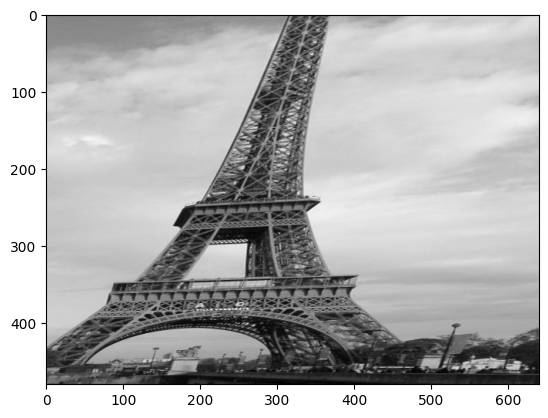

In [60]:
# extract lines for the image

import cv2

conf_lines = {
    "min_length": 15,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3,
        },
    },

}

model2 = DeepLSD(conf_lines)


model2.eval()
with torch.no_grad():
    pred2 = model2({"image": numpy_image_to_torch(imageh)[None]})
    
    # pred2 = {k: v[0].cpu().numpy() for k, v in pred2.items()}
    lines = pred2["lines"]
    # line_scores = pred2["line_scores"]
    # valid_lines = pred2["valid_lines"]
    
# Show lines

import matplotlib.pyplot as plt
plt.imshow(imageh, cmap='gray')
for line in lines:
    plt.plot(line[:, 0], line[:, 1], c='r')

In [61]:
import torch
import matplotlib.pyplot as plt


#image_path = '/home/egoedeke/Downloads/MegaDepth_v1/phoenix/S6/zl548/MegaDepth_v1/0000/dense1/imgs/11037727_d36d4462ad_o.jpg'

image_path = '/home/egoedeke/OneDrive/ETH/3DVision/glue-factory/mini_depth_100/813789103_347fe668e3_o.jpg'

# Assume that `image` is your input image and `numpy_image_to_torch` is a function that converts numpy images to PyTorch tensors
#image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # replace with your image file path

gray = cv2.imread(image_path, 0)


conf_lines = {
    "min_length": 10,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 1,
        },
    },

}

model2 = DeepLSD(conf_lines)

# Set the model to evaluation mode
model2.eval()

# Disable gradient calculation
with torch.no_grad():
    # Get predictions from the model
    # pred = model2({"image": numpy_image_to_torch(imageh)[None]})
    pred = model2({"image": numpy_image_to_torch(gray)[None]})
    


    # Move predictions to CPU and convert to numpy arrays
    pred = {k: v[0].squeeze().cpu().numpy() for k, v in pred2.items()}

# Extract lines from the predictions
lines = pred["lines"]

# Plot the original image and overlay the detected lines
plt.imshow(image, cmap='gray')
for line in lines:
    plt.plot(line[:, 0], line[:, 1], c='r')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'